# Analysis of Benchmark Results

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('results.csv')

benchmarks = []
for name, benchmark in data.groupby('Benchmark'):
    sorted_benchmark = benchmark.sort_values('Throughput (ops/ms)', ascending=False)
    benchmarks.append(sorted_benchmark)

pd.concat(benchmarks, ignore_index=True)

,Benchmark,Toolchain,Engine,Throughput (ops/ms)
0,ArrayIntCreateBenchmark,JVM (C2),OpenJDK (24.0.1),6.789222
1,ArrayIntCreateBenchmark,JVM (Tiered Compilation),OpenJDK (24.0.1),6.526366
2,ArrayIntCreateBenchmark,J2CL - WASM,V8 (13.9.153),6.353597
3,ArrayIntCreateBenchmark,J2CL - WASM,SpiderMonkey (v140.0b9),2.728834
4,ArrayIntCreateBenchmark,J2CL - JS,V8 (13.9.153),1.104686
...,...,...,...,...
451,TreeMapStringPutBenchmark,JVM (Tiered Compilation),OpenJDK (24.0.1),15.343688
452,TreeMapStringPutBenchmark,J2CL - WASM,V8 (13.9.153),8.402706
453,TreeMapStringPutBenchmark,J2CL - WASM,SpiderMonkey (v140.0b9),5.728045
454,TreeMapStringPutBenchmark,J2CL - JS,V8 (13.9.153),3.001626


# Visualizing Benchmark Results

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
sns.set_palette("Dark2")

shortened = data.replace({
    'JVM (Tiered Compilation)': 'JVM (TC)',
    'J2CL - WASM': 'Wasm',
    'J2CL - JS': 'JS'
})

shortened = shortened.replace({
    'OpenJDK (24.0.1)': '',
    'V8 (13.9.153)': 'V8',
    'SpiderMonkey (v140.0b9)': 'SM'
})


## Overall Throughput Comparison

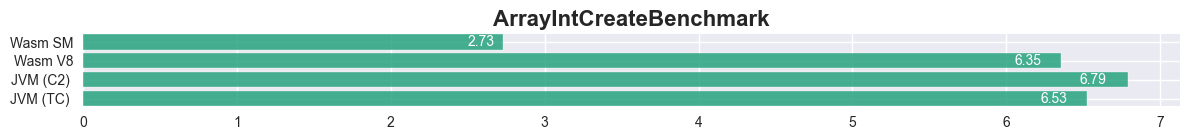

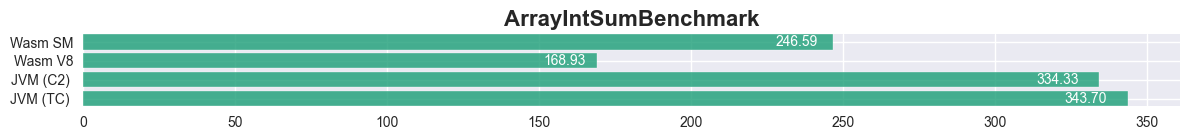

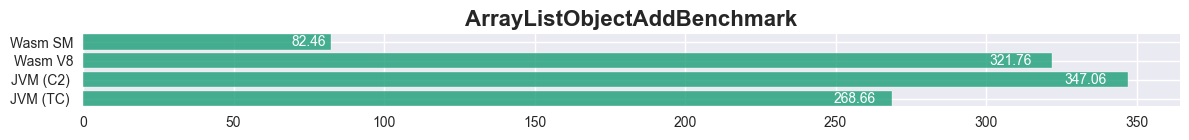

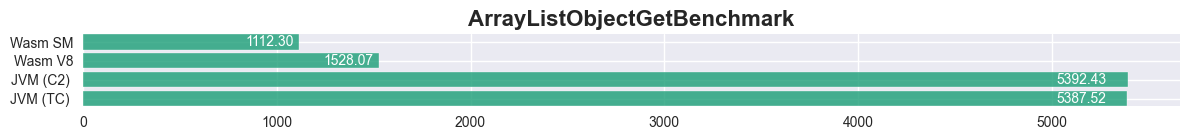

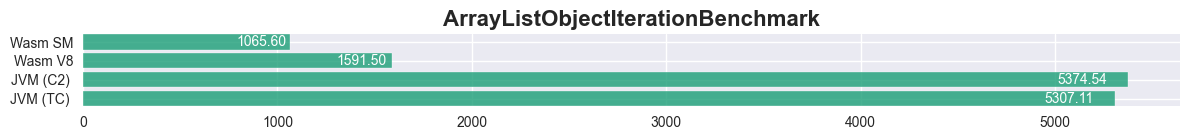

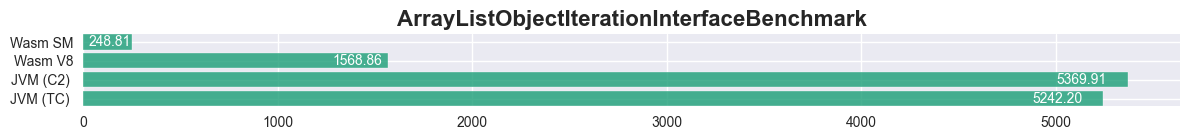

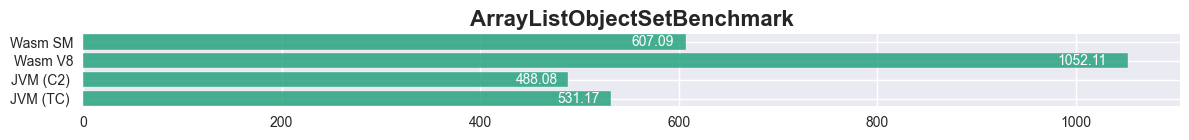

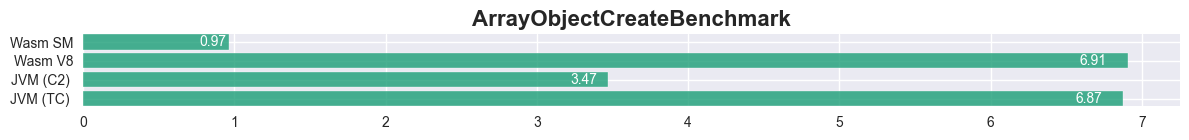

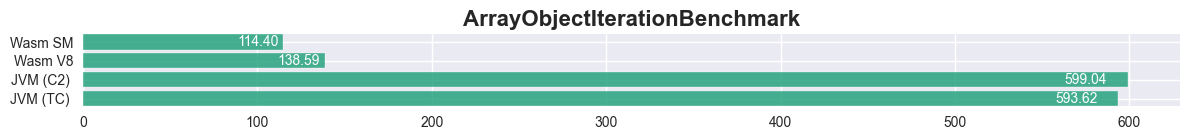

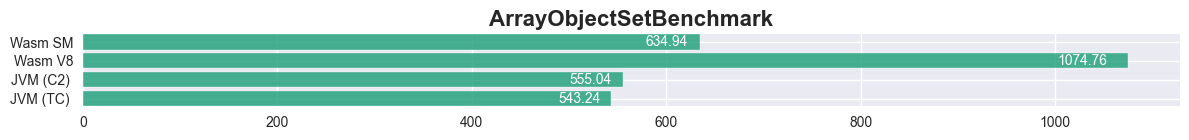

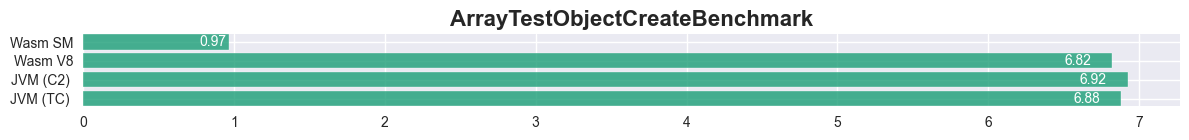

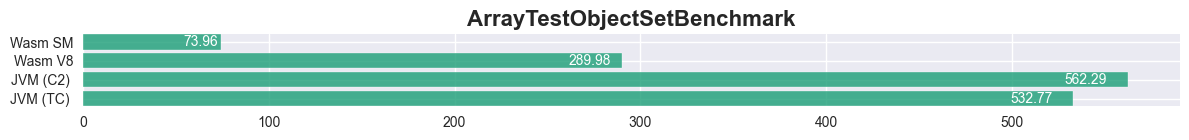

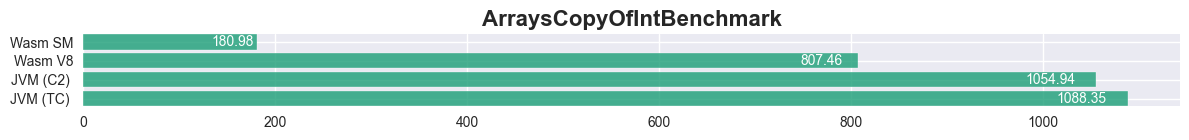

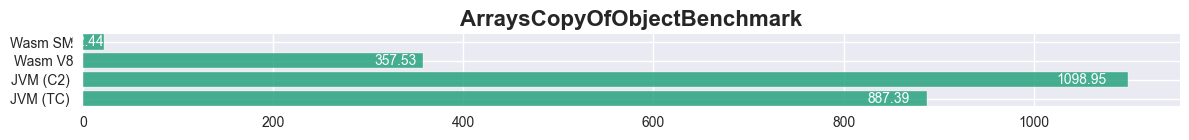

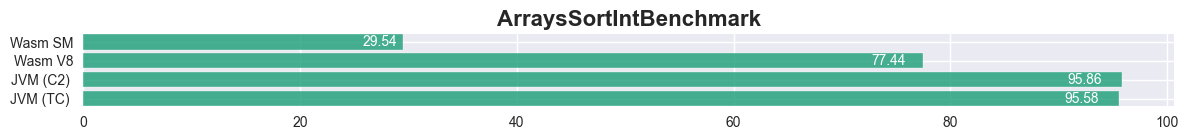

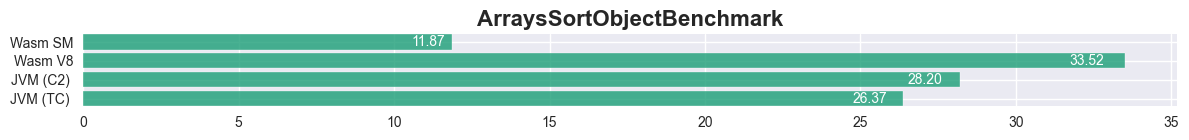

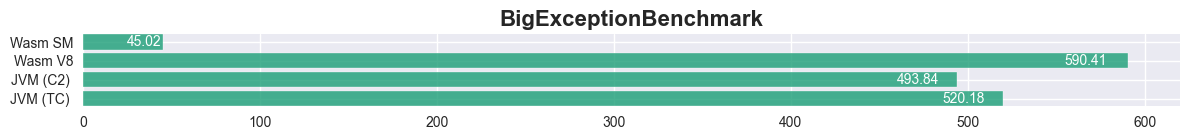

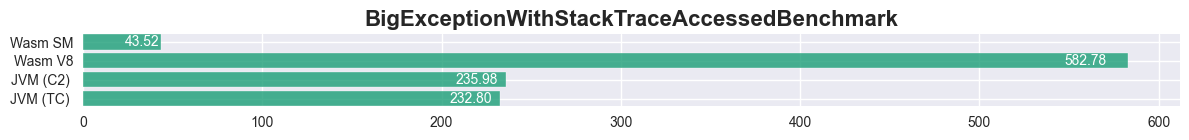

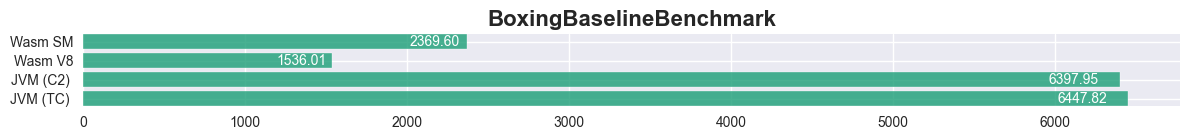

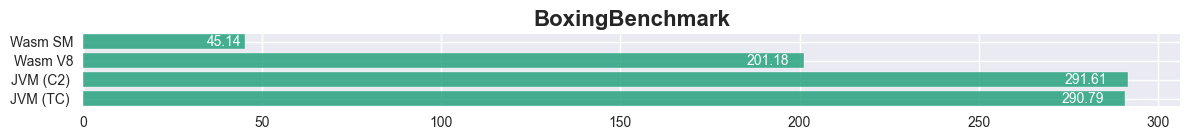

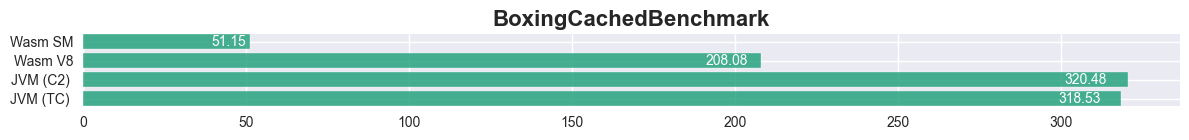

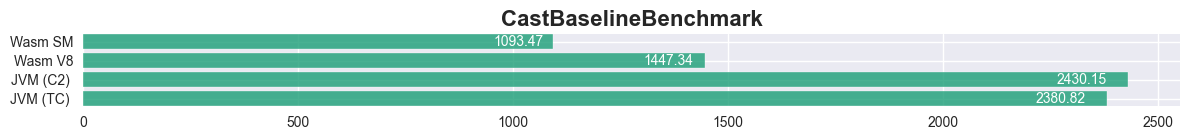

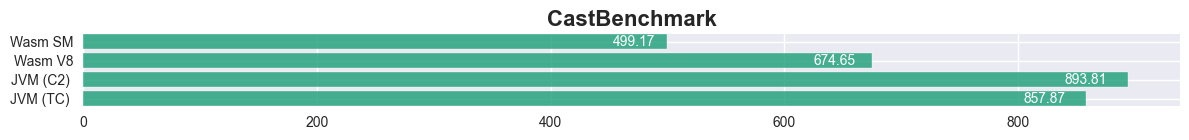

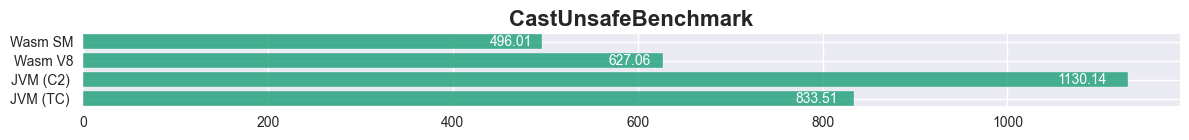

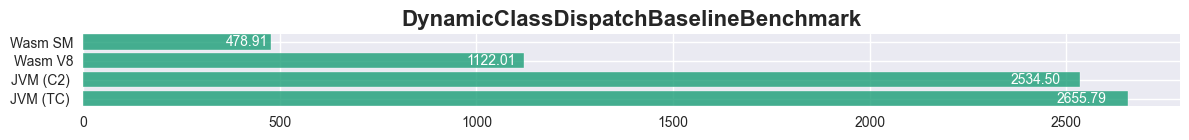

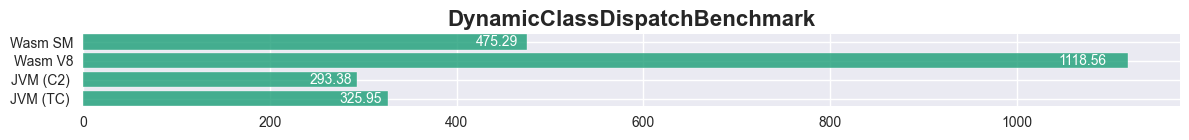

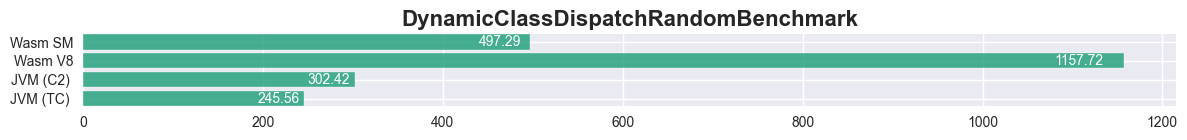

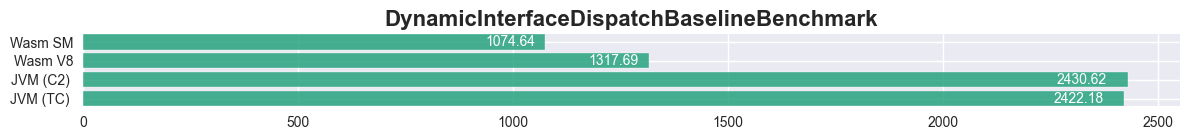

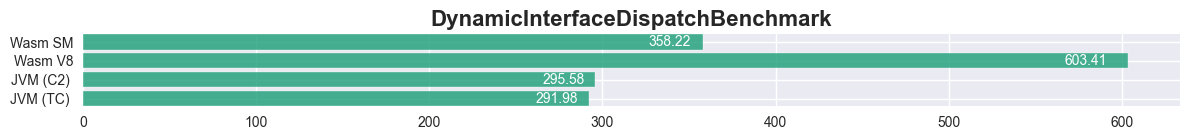

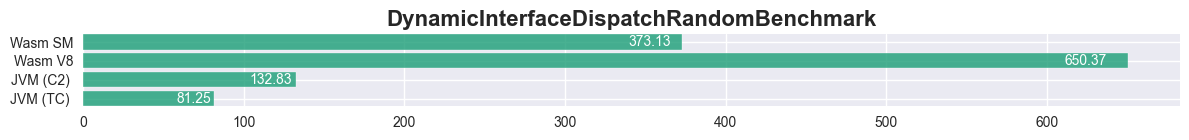

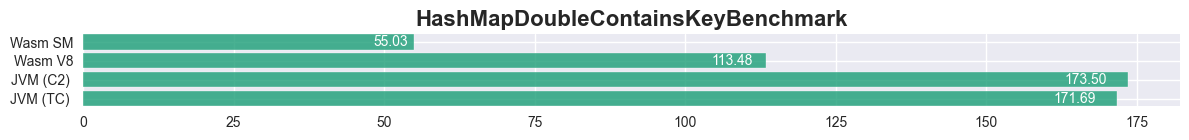

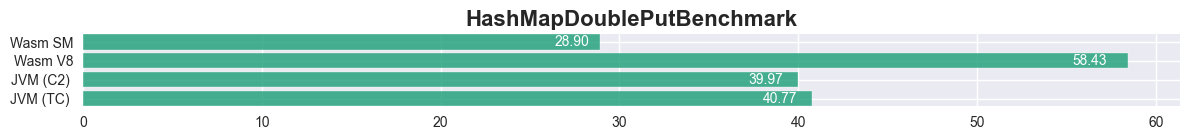

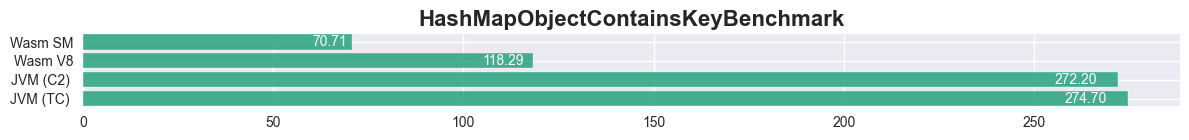

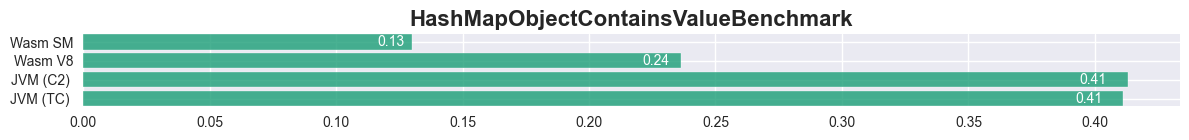

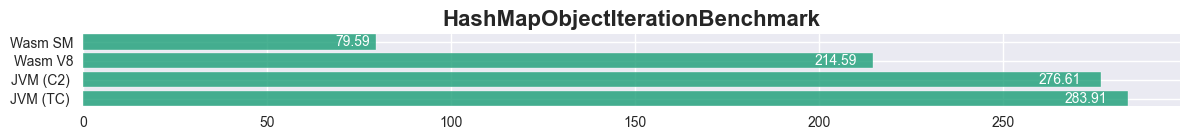

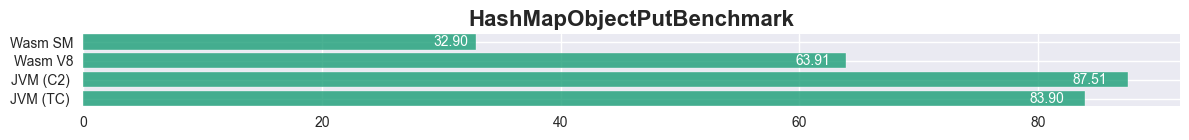

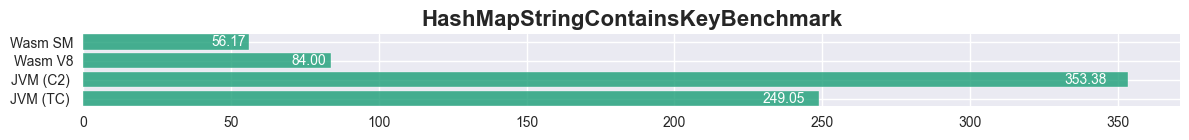

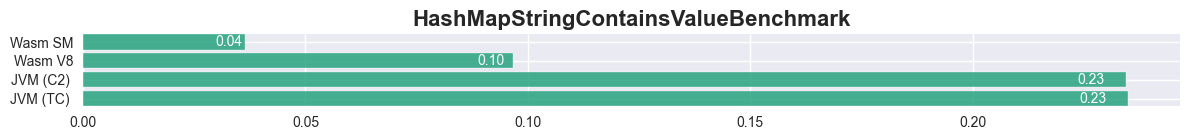

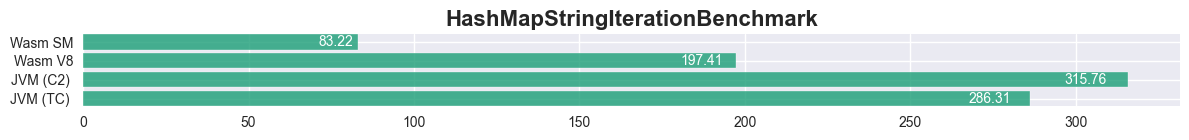

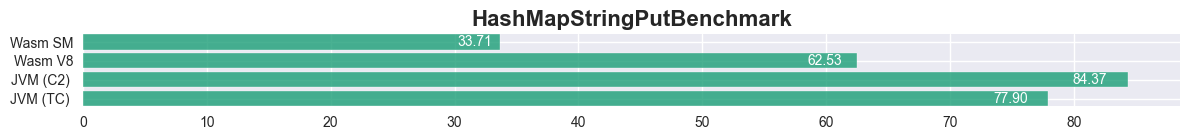

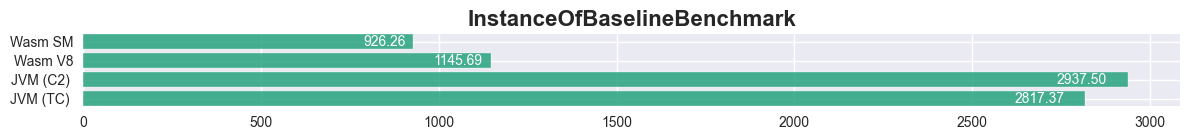

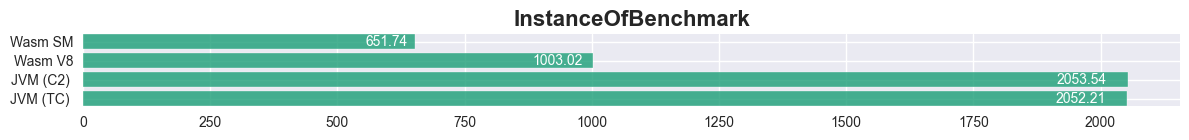

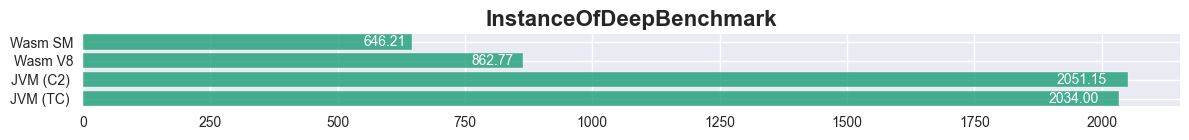

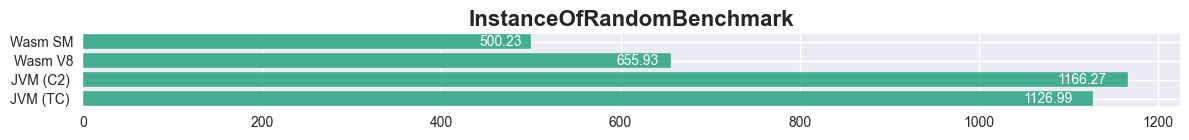

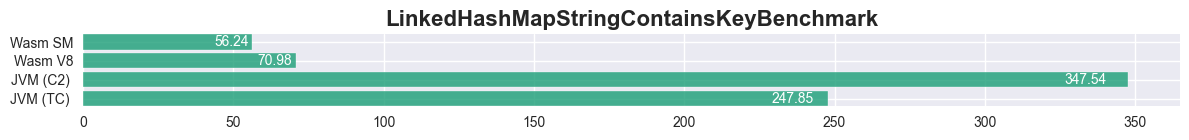

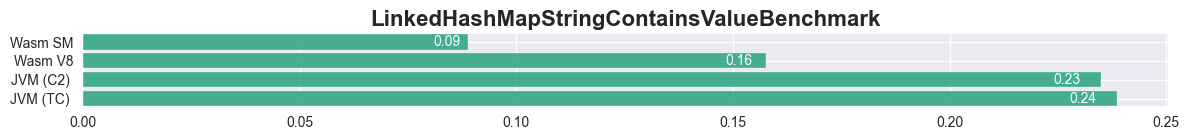

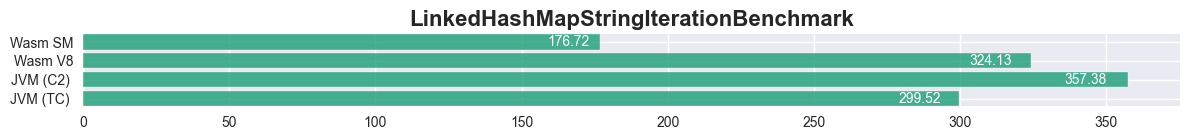

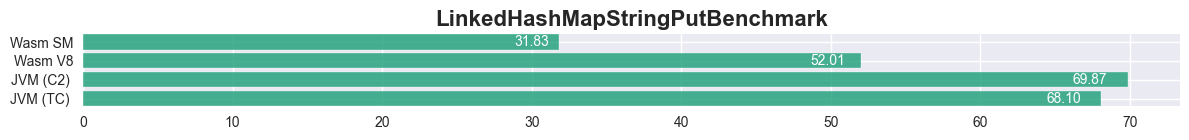

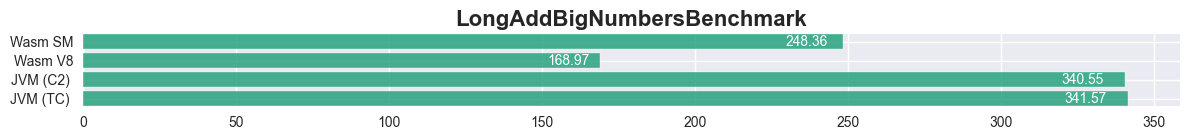

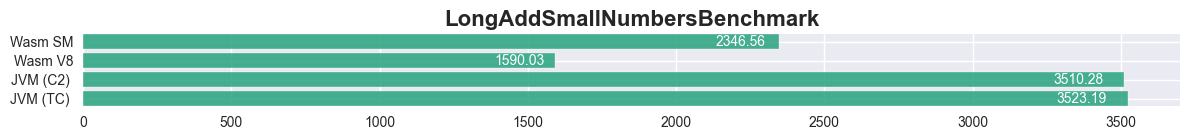

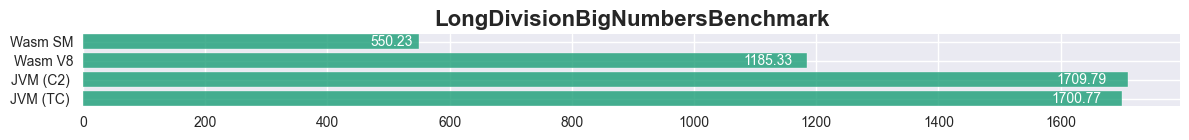

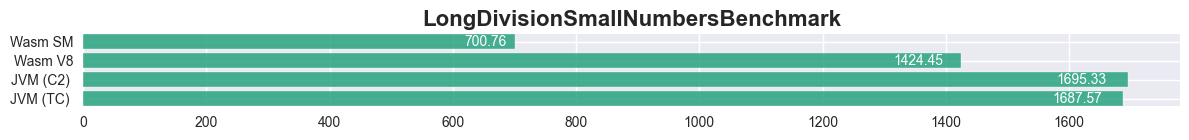

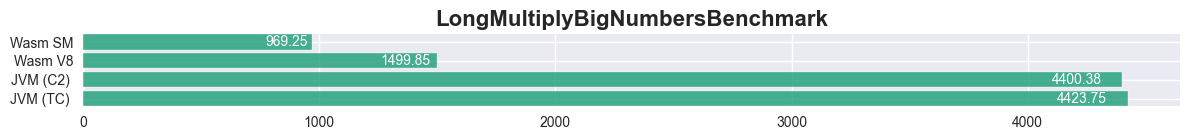

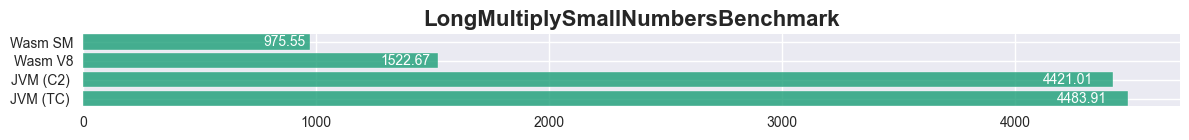

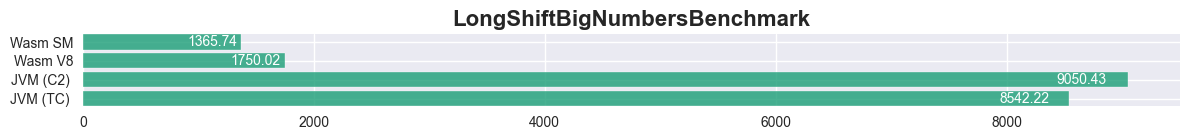

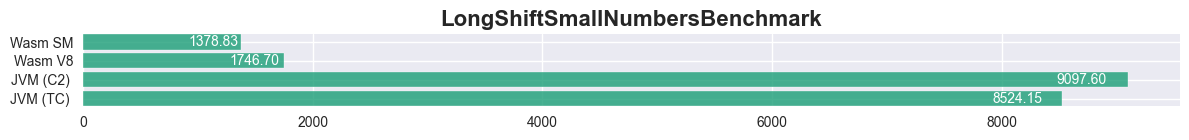

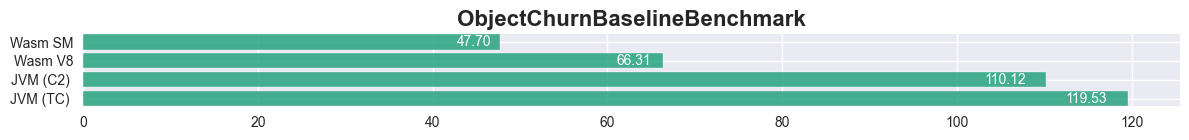

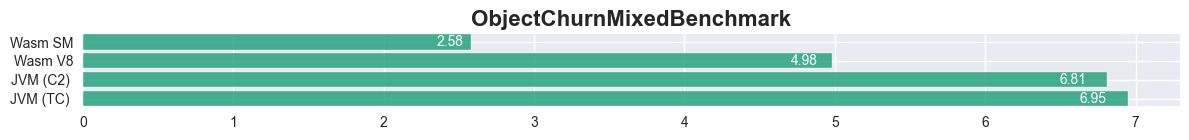

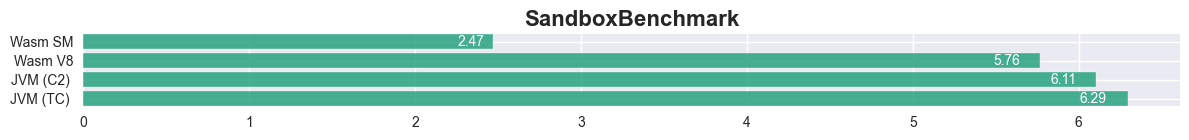

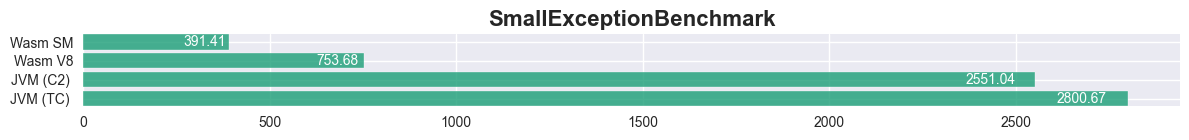

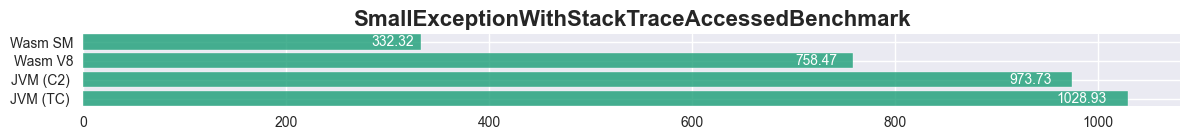

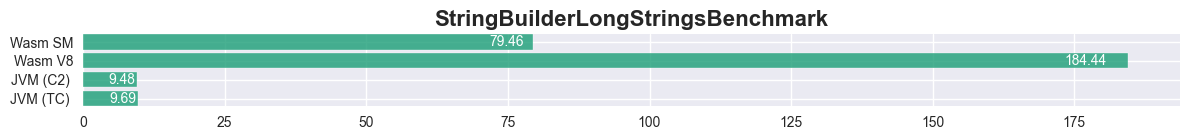

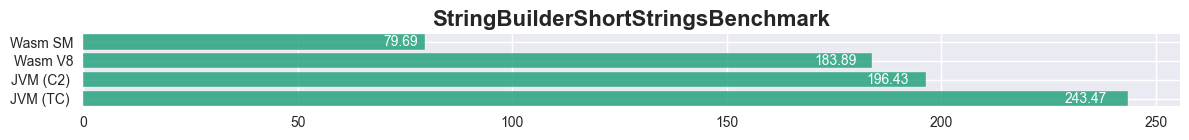

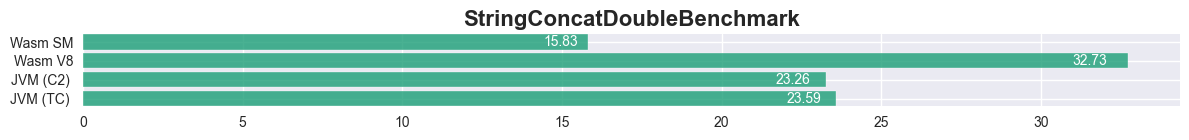

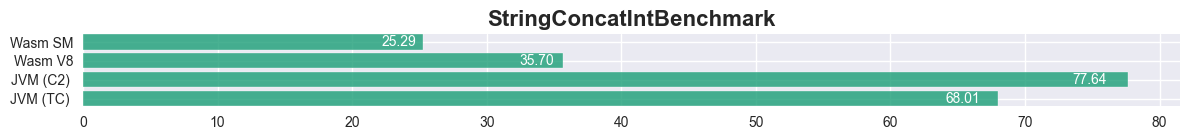

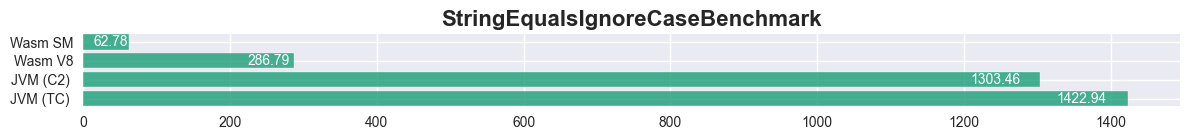

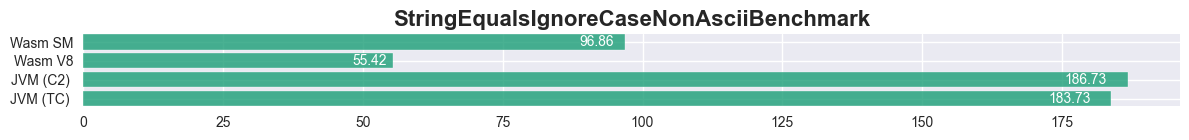

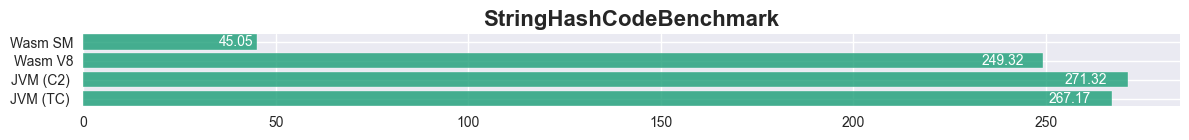

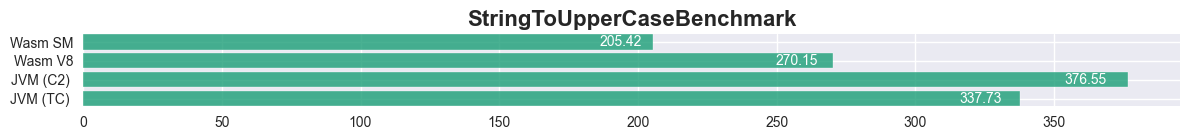

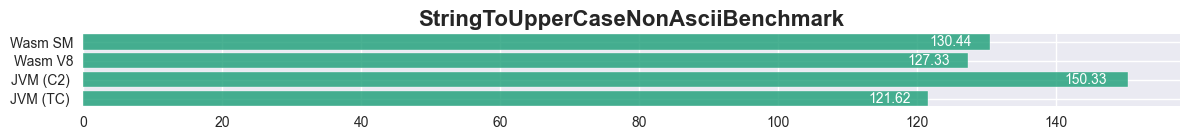

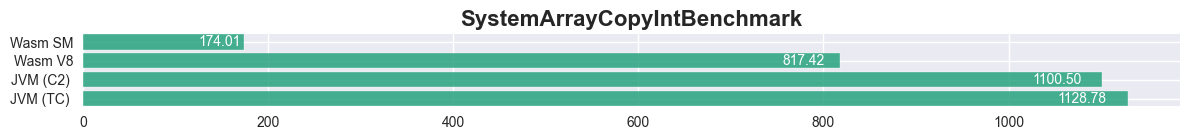

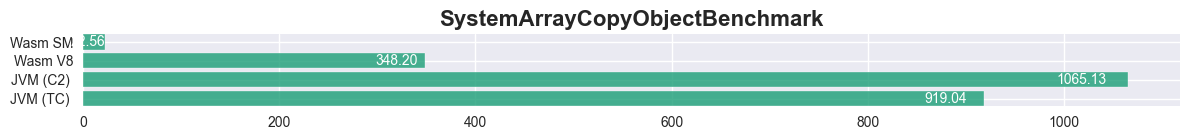

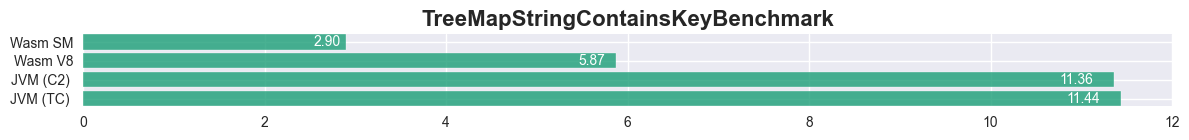

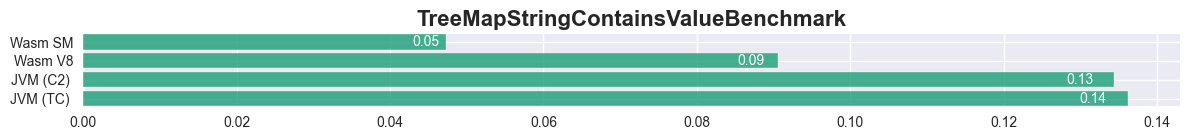

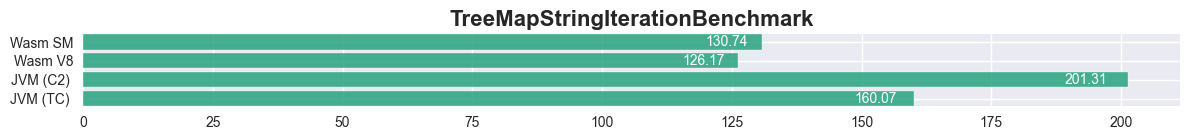

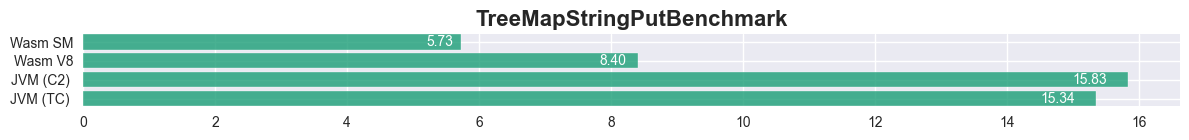

In [3]:
overall = shortened.copy()

overall['Label'] = overall['Toolchain'] + ' ' + overall['Engine']
overall = overall.drop(['Toolchain', 'Engine'], axis=1)

overall = overall[overall['Label'] != 'JS V8']
overall = overall[overall['Label'] != 'JS SM']

for name, benchmarks in overall.groupby('Benchmark'):
    plt.figure(figsize=(max(12.0, len(benchmarks) * 0.25), 1.5))
    plt.margins(y=0)

    plt.title(f'{name}', fontsize=16, fontweight='bold')

    bars = plt.barh(
        range(len(benchmarks)),
        benchmarks['Throughput (ops/ms)'],
        alpha=0.8
    )
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width - width * 0.02, bar.get_y() + bar.get_height() / 2., f'{width:.2f}', ha='right', va='center', fontsize=10, color='white')

    plt.yticks(range(len(benchmarks)), benchmarks['Label'])
    plt.tight_layout()
    plt.show()

### Do JVM and Wasm perform better than JS?

In [4]:
# Group data by benchmark and toolchain
# For simplicity, we'll use the original data and focus on the toolchain
# We'll consider JVM (both Tiered Compilation and C2) as one category

toolchain_data = data.copy()
toolchain_data['Toolchain'] = toolchain_data['Toolchain'].str.replace(r' \(.*\)', '', regex=True)
toolchain_data['Toolchain'] = toolchain_data['Toolchain'].replace({'J2CL - WASM': 'Wasm', 'J2CL - JS': 'JS'})

benchmark_results = {}
for benchmark_name, benchmark_group in toolchain_data.groupby('Benchmark'):
    # Get the max throughput for each toolchain in this benchmark
    max_by_toolchain = benchmark_group.groupby('Toolchain')['Throughput (ops/ms)'].max()

    # Check if both JVM and Wasm outperform JS
    jvm_better_than_js = max_by_toolchain['JVM'] > max_by_toolchain['JS']
    wasm_better_than_js = max_by_toolchain['Wasm'] > max_by_toolchain['JS']
    both_better = jvm_better_than_js and wasm_better_than_js

    benchmark_results[benchmark_name] = {
        'JVM': max_by_toolchain['JVM'],
        'Wasm': max_by_toolchain['Wasm'],
        'JS': max_by_toolchain['JS'],
        'JVM better than JS': jvm_better_than_js,
        'Wasm better than JS': wasm_better_than_js,
        'Both better than JS': both_better
    }

# Convert to DataFrame for better visualization
results_df = pd.DataFrame(benchmark_results).T
results_df = results_df.sort_values('Both better than JS', ascending=False)

# Display the results
total_benchmarks = len(results_df)
jvm_better_count = results_df['JVM better than JS'].astype(bool).sum()
wasm_better_count = results_df['Wasm better than JS'].astype(bool).sum()
both_better_count = results_df['Both better than JS'].astype(bool).sum()

jvm_better_percentage = (jvm_better_count / total_benchmarks) * 100
wasm_better_percentage = (wasm_better_count / total_benchmarks) * 100
both_better_percentage = (both_better_count / total_benchmarks) * 100

print(f"Total number of benchmarks: {total_benchmarks}")
print(f"Number of benchmarks where JVM outperforms JS: {jvm_better_count} ({jvm_better_percentage:.1f}%)")
print(f"Number of benchmarks where Wasm outperforms JS: {wasm_better_count} ({wasm_better_percentage:.1f}%)")
print(f"Number of benchmarks where both JVM and Wasm outperform JS: {both_better_count} ({both_better_percentage:.1f}%)")

# Answer the question
all_benchmarks_both_better = results_df['Both better than JS'].all()
print(f"\nDo both JVM & Wasm perform better than JS? {'Yes' if both_better_percentage > 50 else 'No'}")

# Let's see which benchmarks don't follow this pattern
if not all_benchmarks_both_better:
    print("\nBenchmarks where not both JVM and Wasm outperform JS:")
    exceptions = results_df[~results_df['Both better than JS']]

    for idx, row in exceptions.iterrows():
        print(f"{idx}:")
        benchmark_data = data[data['Benchmark'] == idx]
        # Find the maximum length of toolchain and engine names for alignment
        max_toolchain_len = benchmark_data['Toolchain'].str.len().max()
        max_engine_len = benchmark_data['Engine'].str.len().max()

        for _, perm in benchmark_data.iterrows():
            toolchain = perm['Toolchain']
            engine = perm['Engine']
            throughput = perm['Throughput (ops/ms)']
            print(f"    {toolchain:{max_toolchain_len}} on {engine:{max_engine_len}} : {throughput:8.2f} ops/ms")
        print()

Total number of benchmarks: 76
Number of benchmarks where JVM outperforms JS: 63 (82.9%)
Number of benchmarks where Wasm outperforms JS: 54 (71.1%)
Number of benchmarks where both JVM and Wasm outperform JS: 50 (65.8%)

Do both JVM & Wasm perform better than JS? Yes

Benchmarks where not both JVM and Wasm outperform JS:
CastBaselineBenchmark:
    JVM (Tiered Compilation) on OpenJDK (24.0.1)        :  2380.82 ops/ms
    JVM (C2)                 on OpenJDK (24.0.1)        :  2430.15 ops/ms
    J2CL - JS                on V8 (13.9.153)           :  1461.24 ops/ms
    J2CL - JS                on SpiderMonkey (v140.0b9) :   802.74 ops/ms
    J2CL - WASM              on V8 (13.9.153)           :  1447.34 ops/ms
    J2CL - WASM              on SpiderMonkey (v140.0b9) :  1093.47 ops/ms

StringBuilderShortStringsBenchmark:
    JVM (Tiered Compilation) on OpenJDK (24.0.1)        :   243.47 ops/ms
    JVM (C2)                 on OpenJDK (24.0.1)        :   196.43 ops/ms
    J2CL - JS             

## Does the JVM perform better than Wasm V8 and Wasm SpiderMonkey?

In [5]:
platform_data = data.copy()
platform_data['Toolchain'] = platform_data['Toolchain'].str.replace(r' \(.*\)', '', regex=True)
platform_data['Toolchain'] = platform_data['Toolchain'].replace({'J2CL - WASM': 'Wasm', 'J2CL - JS': 'JS'})

# Create a combined platform identifier for Wasm platforms
platform_data['Platform'] = platform_data.apply(
    lambda row: f"{row['Toolchain']} {row['Engine']}" if row['Toolchain'] == 'Wasm' else row['Toolchain'],
    axis=1
)

# Now let's analyze each benchmark to compare JVM against Wasm V8 and Wasm SpiderMonkey
benchmark_results = {}
for benchmark_name, benchmark_group in platform_data.groupby('Benchmark'):
    # Get the max throughput for JVM
    jvm_data = benchmark_group[benchmark_group['Toolchain'] == 'JVM']
    max_jvm = jvm_data['Throughput (ops/ms)'].max()

    # Get the max throughput for Wasm on V8
    wasm_v8_data = benchmark_group[(benchmark_group['Toolchain'] == 'Wasm') & 
                                  (benchmark_group['Engine'] == 'V8 (13.9.153)')]
    max_wasm_v8 = wasm_v8_data['Throughput (ops/ms)'].max() if not wasm_v8_data.empty else 0

    # Get the max throughput for Wasm on SpiderMonkey
    wasm_sm_data = benchmark_group[(benchmark_group['Toolchain'] == 'Wasm') & 
                                  (benchmark_group['Engine'] == 'SpiderMonkey (v140.0b9)')]
    max_wasm_sm = wasm_sm_data['Throughput (ops/ms)'].max() if not wasm_sm_data.empty else 0

    # Compare JVM against each Wasm platform
    jvm_better_than_wasm_v8 = max_jvm > max_wasm_v8
    jvm_better_than_wasm_sm = max_jvm > max_wasm_sm
    jvm_better_than_both = jvm_better_than_wasm_v8 and jvm_better_than_wasm_sm

    benchmark_results[benchmark_name] = {
        'JVM': max_jvm,
        'Wasm V8': max_wasm_v8,
        'Wasm SM': max_wasm_sm,
        'JVM better than Wasm V8': jvm_better_than_wasm_v8,
        'JVM better than Wasm SM': jvm_better_than_wasm_sm,
        'JVM better than both': jvm_better_than_both
    }

# Convert to DataFrame for better visualization
results_df = pd.DataFrame(benchmark_results).T
results_df = results_df.sort_values('JVM better than both', ascending=False)

# Calculate statistics
total_benchmarks = len(results_df)
jvm_better_than_v8_count = results_df['JVM better than Wasm V8'].astype(bool).sum()
jvm_better_than_sm_count = results_df['JVM better than Wasm SM'].astype(bool).sum()
jvm_better_than_both_count = results_df['JVM better than both'].astype(bool).sum()

jvm_better_than_v8_percentage = (jvm_better_than_v8_count / total_benchmarks) * 100
jvm_better_than_sm_percentage = (jvm_better_than_sm_count / total_benchmarks) * 100
jvm_better_than_both_percentage = (jvm_better_than_both_count / total_benchmarks) * 100

# Display the results
print(f"Total number of benchmarks: {total_benchmarks}")
print(f"Number of benchmarks where JVM outperforms Wasm V8: {jvm_better_than_v8_count} ({jvm_better_than_v8_percentage:.1f}%)")
print(f"Number of benchmarks where JVM outperforms Wasm SpiderMonkey: {jvm_better_than_sm_count} ({jvm_better_than_sm_percentage:.1f}%)")
print(f"Number of benchmarks where JVM outperforms both Wasm platforms: {jvm_better_than_both_count} ({jvm_better_than_both_percentage:.1f}%)")

# Answer the question
print(f"\nDoes the JVM perform better than Wasm V8 and Wasm SpiderMonkey? {'Yes' if jvm_better_than_both_percentage > 50 else 'No'}")

# Let's see which benchmarks don't follow this pattern
if jvm_better_than_both_count < total_benchmarks:
    print("\nBenchmarks where JVM doesn't outperform both Wasm platforms:")
    exceptions = results_df[~results_df['JVM better than both']]

    for idx, row in exceptions.iterrows():
        print(f"{idx}:")
        benchmark_data = data[data['Benchmark'] == idx]
        # Find the maximum length of toolchain and engine names for alignment
        max_toolchain_len = benchmark_data['Toolchain'].str.len().max()
        max_engine_len = benchmark_data['Engine'].str.len().max()

        for _, perm in benchmark_data.iterrows():
            toolchain = perm['Toolchain']
            engine = perm['Engine']
            throughput = perm['Throughput (ops/ms)']
            print(f"    {toolchain:{max_toolchain_len}} on {engine:{max_engine_len}} : {throughput:8.2f} ops/ms")
        print()


Total number of benchmarks: 76
Number of benchmarks where JVM outperforms Wasm V8: 63 (82.9%)
Number of benchmarks where JVM outperforms Wasm SpiderMonkey: 69 (90.8%)
Number of benchmarks where JVM outperforms both Wasm platforms: 63 (82.9%)

Does the JVM perform better than Wasm V8 and Wasm SpiderMonkey? Yes

Benchmarks where JVM doesn't outperform both Wasm platforms:
ArrayObjectSetBenchmark:
    JVM (Tiered Compilation) on OpenJDK (24.0.1)        :   543.24 ops/ms
    JVM (C2)                 on OpenJDK (24.0.1)        :   555.04 ops/ms
    J2CL - JS                on V8 (13.9.153)           :  2427.87 ops/ms
    J2CL - JS                on SpiderMonkey (v140.0b9) :   971.21 ops/ms
    J2CL - WASM              on V8 (13.9.153)           :  1074.76 ops/ms
    J2CL - WASM              on SpiderMonkey (v140.0b9) :   634.94 ops/ms

HashMapDoublePutBenchmark:
    JVM (Tiered Compilation) on OpenJDK (24.0.1)        :    40.77 ops/ms
    JVM (C2)                 on OpenJDK (24.0.1)        

## Does the Wasm V8 perform better than Wasm SpiderMonkey?

## Most drastic differences between JVM and Wasm V8

In [6]:
wasm_benchmark_results = {}
for benchmark_name, benchmark_group in platform_data.groupby('Benchmark'):
    # Get the max throughput for Wasm on V8
    wasm_v8_data = benchmark_group[(benchmark_group['Toolchain'] == 'Wasm') &
                                  (benchmark_group['Engine'] == 'V8 (13.9.153)')]
    max_wasm_v8 = wasm_v8_data['Throughput (ops/ms)'].max() if not wasm_v8_data.empty else 0

    # Get the max throughput for Wasm on SpiderMonkey
    wasm_sm_data = benchmark_group[(benchmark_group['Toolchain'] == 'Wasm') &
                                  (benchmark_group['Engine'] == 'SpiderMonkey (v140.0b9)')]
    max_wasm_sm = wasm_sm_data['Throughput (ops/ms)'].max() if not wasm_sm_data.empty else 0

    # Skip benchmarks where either engine has no data
    if max_wasm_v8 == 0 or max_wasm_sm == 0:
        continue

    # Compare Wasm V8 against Wasm SpiderMonkey
    v8_better_than_sm = max_wasm_v8 > max_wasm_sm

    # Calculate performance ratio
    if max_wasm_sm > 0:
        v8_to_sm_ratio = max_wasm_v8 / max_wasm_sm
    else:
        v8_to_sm_ratio = float('inf')

    wasm_benchmark_results[benchmark_name] = {
        'Wasm V8': max_wasm_v8,
        'Wasm SM': max_wasm_sm,
        'V8 better than SM': v8_better_than_sm,
        'V8/SM Ratio': v8_to_sm_ratio
    }

# Convert to DataFrame for better visualization
wasm_results_df = pd.DataFrame(wasm_benchmark_results).T
wasm_results_df = wasm_results_df.sort_values('V8 better than SM', ascending=False)

# Calculate statistics
total_wasm_benchmarks = len(wasm_results_df)
v8_better_count = wasm_results_df['V8 better than SM'].astype(bool).sum()
sm_better_count = total_wasm_benchmarks - v8_better_count
v8_better_percentage = (v8_better_count / total_wasm_benchmarks) * 100
sm_better_percentage = (sm_better_count / total_wasm_benchmarks) * 100

# Display the results
print(f"Total number of benchmarks with both Wasm V8 and Wasm SpiderMonkey data: {total_wasm_benchmarks}")
print(f"Number of benchmarks where Wasm V8 outperforms Wasm SpiderMonkey: {v8_better_count} ({v8_better_percentage:.1f}%)")
print(f"Number of benchmarks where Wasm SpiderMonkey outperforms Wasm V8: {sm_better_count} ({sm_better_percentage:.1f}%)")

# Answer the question
v8_generally_better = v8_better_count > sm_better_count
print(f"\nDoes the Wasm V8 perform better than Wasm SpiderMonkey? {'Yes' if v8_generally_better else 'No'}, V8 wins on {v8_better_percentage:.1f}% of benchmarks ({v8_better_count} out of {total_wasm_benchmarks})")

# Let's see the distribution of performance ratios
avg_ratio = wasm_results_df['V8/SM Ratio'].mean()
median_ratio = wasm_results_df['V8/SM Ratio'].median()
print(f"\nOn average, Wasm V8 is {avg_ratio:.2f}x the speed of Wasm SpiderMonkey (median: {median_ratio:.2f}x)")

# Let's see which benchmarks have the most extreme differences
if v8_better_count > 0:
    top_v8_advantage = wasm_results_df[wasm_results_df['V8 better than SM']].sort_values('V8/SM Ratio', ascending=False).head(5)
    print("\nTop 5 benchmarks where Wasm V8 has the biggest advantage over Wasm SpiderMonkey:")
    for idx, row in top_v8_advantage.iterrows():
        print(f"{idx}: V8 is {row['V8/SM Ratio']:.2f}x faster (V8: {row['Wasm V8']:.2f} ops/ms, SM: {row['Wasm SM']:.2f} ops/ms)")

if sm_better_count > 0:
    top_sm_advantage = wasm_results_df[~wasm_results_df['V8 better than SM']].sort_values('V8/SM Ratio').head(5)
    print("\nTop 5 benchmarks where Wasm SpiderMonkey has the biggest advantage over Wasm V8:")
    for idx, row in top_sm_advantage.iterrows():
        sm_to_v8_ratio = 1 / row['V8/SM Ratio']
        print(f"{idx}: SpiderMonkey is {sm_to_v8_ratio:.2f}x faster (SM: {row['Wasm SM']:.2f} ops/ms, V8: {row['Wasm V8']:.2f} ops/ms)")

# Let's see the detailed permutations for some interesting benchmarks
print("\nDetailed permutations for selected benchmarks:")
# Select a few interesting benchmarks (top 3 where V8 wins and top 3 where SM wins)
interesting_benchmarks = []
if v8_better_count > 0:
    interesting_benchmarks.extend(top_v8_advantage.index[:min(3, len(top_v8_advantage))])
if sm_better_count > 0:
    interesting_benchmarks.extend(top_sm_advantage.index[:min(3, len(top_sm_advantage))])

for benchmark_name in interesting_benchmarks:
    print(f"{benchmark_name}:")
    benchmark_data = data[data['Benchmark'] == benchmark_name]
    # Filter to only show Wasm entries
    wasm_data = benchmark_data[benchmark_data['Toolchain'].str.contains('WASM')]

    # Find the maximum length of toolchain and engine names for alignment
    max_toolchain_len = wasm_data['Toolchain'].str.len().max()
    max_engine_len = wasm_data['Engine'].str.len().max()

    for _, perm in wasm_data.iterrows():
        toolchain = perm['Toolchain']
        engine = perm['Engine']
        throughput = perm['Throughput (ops/ms)']
        print(f"    {toolchain:{max_toolchain_len}} on {engine:{max_engine_len}} : {throughput:8.2f} ops/ms")
    print()


Total number of benchmarks with both Wasm V8 and Wasm SpiderMonkey data: 76
Number of benchmarks where Wasm V8 outperforms Wasm SpiderMonkey: 69 (90.8%)
Number of benchmarks where Wasm SpiderMonkey outperforms Wasm V8: 7 (9.2%)

Does the Wasm V8 perform better than Wasm SpiderMonkey? Yes, V8 wins on 90.8% of benchmarks (69 out of 76)

On average, Wasm V8 is 2.86x the speed of Wasm SpiderMonkey (median: 1.88x)

Top 5 benchmarks where Wasm V8 has the biggest advantage over Wasm SpiderMonkey:
ArraysCopyOfObjectBenchmark: V8 is 15.93x faster (V8: 357.53 ops/ms, SM: 22.44 ops/ms)
SystemArrayCopyObjectBenchmark: V8 is 15.43x faster (V8: 348.20 ops/ms, SM: 22.56 ops/ms)
BigExceptionWithStackTraceAccessedBenchmark: V8 is 13.39x faster (V8: 582.78 ops/ms, SM: 43.52 ops/ms)
BigExceptionBenchmark: V8 is 13.12x faster (V8: 590.41 ops/ms, SM: 45.02 ops/ms)
ArrayObjectCreateBenchmark: V8 is 7.14x faster (V8: 6.91 ops/ms, SM: 0.97 ops/ms)

Top 5 benchmarks where Wasm SpiderMonkey has the biggest adva

In [7]:
jvm_wasm_v8_comparison = {}

for benchmark_name, benchmark_group in platform_data.groupby('Benchmark'):
    # Get the max throughput for JVM
    jvm_data = benchmark_group[benchmark_group['Toolchain'] == 'JVM']
    max_jvm = jvm_data['Throughput (ops/ms)'].max() if not jvm_data.empty else 0

    # Get the max throughput for Wasm on V8
    wasm_v8_data = benchmark_group[(benchmark_group['Toolchain'] == 'Wasm') & 
                                  (benchmark_group['Engine'] == 'V8 (13.9.153)')]
    max_wasm_v8 = wasm_v8_data['Throughput (ops/ms)'].max() if not wasm_v8_data.empty else 0

    # Calculate performance ratio
    jvm_to_v8_ratio = max_jvm / max_wasm_v8

    jvm_wasm_v8_comparison[benchmark_name] = {
        'JVM': max_jvm,
        'Wasm V8': max_wasm_v8,
        'JVM/V8 Ratio': jvm_to_v8_ratio,
        'JVM better than V8': jvm_to_v8_ratio > 1
    }

# Convert to DataFrame for better visualization
jvm_v8_df = pd.DataFrame(jvm_wasm_v8_comparison).T

# Sort by the absolute difference in ratio (most extreme differences first)
# We'll use log ratio to treat "2x faster" and "2x slower" as equally extreme
jvm_v8_df['Log Ratio'] = np.log2(jvm_v8_df['JVM/V8 Ratio'].astype(float))
jvm_v8_df['Abs Log Ratio'] = np.abs(jvm_v8_df['Log Ratio'].astype(float))
jvm_v8_df = jvm_v8_df.sort_values('Abs Log Ratio', ascending=False)

# Display overall statistics
total_comparisons = len(jvm_v8_df)
jvm_better_count = jvm_v8_df['JVM better than V8'].astype(bool).sum()
v8_better_count = total_comparisons - jvm_better_count
jvm_better_percentage = (jvm_better_count / total_comparisons) * 100
v8_better_percentage = (v8_better_count / total_comparisons) * 100

print(f"Total number of benchmarks: {total_comparisons}")
print(f"Number of benchmarks where JVM outperforms Wasm V8: {jvm_better_count} ({jvm_better_percentage:.1f}%)")
print(f"Number of benchmarks where Wasm V8 outperforms JVM: {v8_better_count} ({v8_better_percentage:.1f}%)")

# Calculate average and median ratios
avg_ratio = jvm_v8_df['JVM/V8 Ratio'].mean()
median_ratio = jvm_v8_df['JVM/V8 Ratio'].median()
print(f"\nOn average, JVM is {avg_ratio:.2f}x the speed of Wasm V8 (median: {median_ratio:.2f}x)")

# Show the top 10 most extreme differences
print("\nTop 10 benchmarks with the most extreme differences between JVM and Wasm V8:")
top_extreme = jvm_v8_df.head(10)

for idx, row in top_extreme.iterrows():
    if row['JVM better than V8']:
        print(f"{idx}: JVM is {row['JVM/V8 Ratio']:.2f}x faster (JVM: {row['JVM']:.2f} ops/ms, V8: {row['Wasm V8']:.2f} ops/ms)")
    else:
        v8_to_jvm_ratio = 1 / row['JVM/V8 Ratio']
        print(f"{idx}: Wasm V8 is {v8_to_jvm_ratio:.2f}x faster (V8: {row['Wasm V8']:.2f} ops/ms, JVM: {row['JVM']:.2f} ops/ms)")

# Let's see the top 5 benchmarks where JVM has the biggest advantage
top_jvm_advantage = jvm_v8_df[jvm_v8_df['JVM better than V8']].sort_values('JVM/V8 Ratio', ascending=False).head(5)
print("\nTop 5 benchmarks where JVM has the biggest advantage over Wasm V8:")
for idx, row in top_jvm_advantage.iterrows():
    print(f"{idx}: JVM is {row['JVM/V8 Ratio']:.2f}x faster (JVM: {row['JVM']:.2f} ops/ms, V8: {row['Wasm V8']:.2f} ops/ms)")

# Let's see the top 5 benchmarks where Wasm V8 has the biggest advantage
top_v8_advantage = jvm_v8_df[~jvm_v8_df['JVM better than V8']].sort_values('JVM/V8 Ratio').head(5)
print("\nTop 5 benchmarks where Wasm V8 has the biggest advantage over JVM:")
for idx, row in top_v8_advantage.iterrows():
    v8_to_jvm_ratio = 1 / row['JVM/V8 Ratio']
    print(f"{idx}: Wasm V8 is {v8_to_jvm_ratio:.2f}x faster (V8: {row['Wasm V8']:.2f} ops/ms, JVM: {row['JVM']:.2f} ops/ms)")

# Let's see the detailed permutations for the most extreme benchmarks
print("\nDetailed permutations for benchmarks with the most extreme differences:")
# Select the top 5 most extreme benchmarks (regardless of which platform is better)
extreme_benchmarks = jvm_v8_df.head(5).index

for benchmark_name in extreme_benchmarks:
    print(f"{benchmark_name}:")
    benchmark_data = data[data['Benchmark'] == benchmark_name]

    # Filter to only show JVM and Wasm V8 entries
    filtered_data = benchmark_data[
        (benchmark_data['Toolchain'].str.contains('JVM')) | 
        ((benchmark_data['Toolchain'].str.contains('WASM')) & (benchmark_data['Engine'] == 'V8 (13.9.153)'))
    ]

    # Find the maximum length of toolchain and engine names for alignment
    max_toolchain_len = filtered_data['Toolchain'].str.len().max()
    max_engine_len = filtered_data['Engine'].str.len().max()

    for _, perm in filtered_data.iterrows():
        toolchain = perm['Toolchain']
        engine = perm['Engine']
        throughput = perm['Throughput (ops/ms)']
        print(f"    {toolchain:{max_toolchain_len}} on {engine:{max_engine_len}} : {throughput:8.2f} ops/ms")
    print()


Total number of benchmarks: 76
Number of benchmarks where JVM outperforms Wasm V8: 63 (82.9%)
Number of benchmarks where Wasm V8 outperforms JVM: 13 (17.1%)

On average, JVM is 1.91x the speed of Wasm V8 (median: 1.53x)

Top 10 benchmarks with the most extreme differences between JVM and Wasm V8:
StringBuilderLongStringsBenchmark: Wasm V8 is 19.04x faster (V8: 184.44 ops/ms, JVM: 9.69 ops/ms)
LongShiftSmallNumbersBenchmark: JVM is 5.21x faster (JVM: 9097.60 ops/ms, V8: 1746.70 ops/ms)
LongShiftBigNumbersBenchmark: JVM is 5.17x faster (JVM: 9050.43 ops/ms, V8: 1750.02 ops/ms)
StringEqualsIgnoreCaseBenchmark: JVM is 4.96x faster (JVM: 1422.94 ops/ms, V8: 286.79 ops/ms)
LinkedHashMapStringContainsKeyBenchmark: JVM is 4.90x faster (JVM: 347.54 ops/ms, V8: 70.98 ops/ms)
DynamicInterfaceDispatchRandomBenchmark: Wasm V8 is 4.90x faster (V8: 650.37 ops/ms, JVM: 132.83 ops/ms)
ArrayObjectIterationBenchmark: JVM is 4.32x faster (JVM: 599.04 ops/ms, V8: 138.59 ops/ms)
HashMapStringContainsKeyBenc

## Dynamic dispatch

Maximum throughput for each benchmark, toolchain, and engine (ops/ms):
Toolchain_Engine                           J2CL - JS on SpiderMonkey (v140.0b9)  J2CL - JS on V8 (13.9.153)  J2CL - WASM on SpiderMonkey (v140.0b9)  J2CL - WASM on V8 (13.9.153)  JVM (C2) on OpenJDK (24.0.1)  JVM (Tiered Compilation) on OpenJDK (24.0.1)
Benchmark                                                                                                                                                                                                                                                    
DynamicClassDispatchBaselineBenchmark                                499.487638                 1420.592600                              478.905762                   1122.005858                   2534.503869                                   2655.785821
DynamicClassDispatchBenchmark                                        101.608124                  476.279127                              475.293839                   1

<Figure size 2000x1200 with 0 Axes>

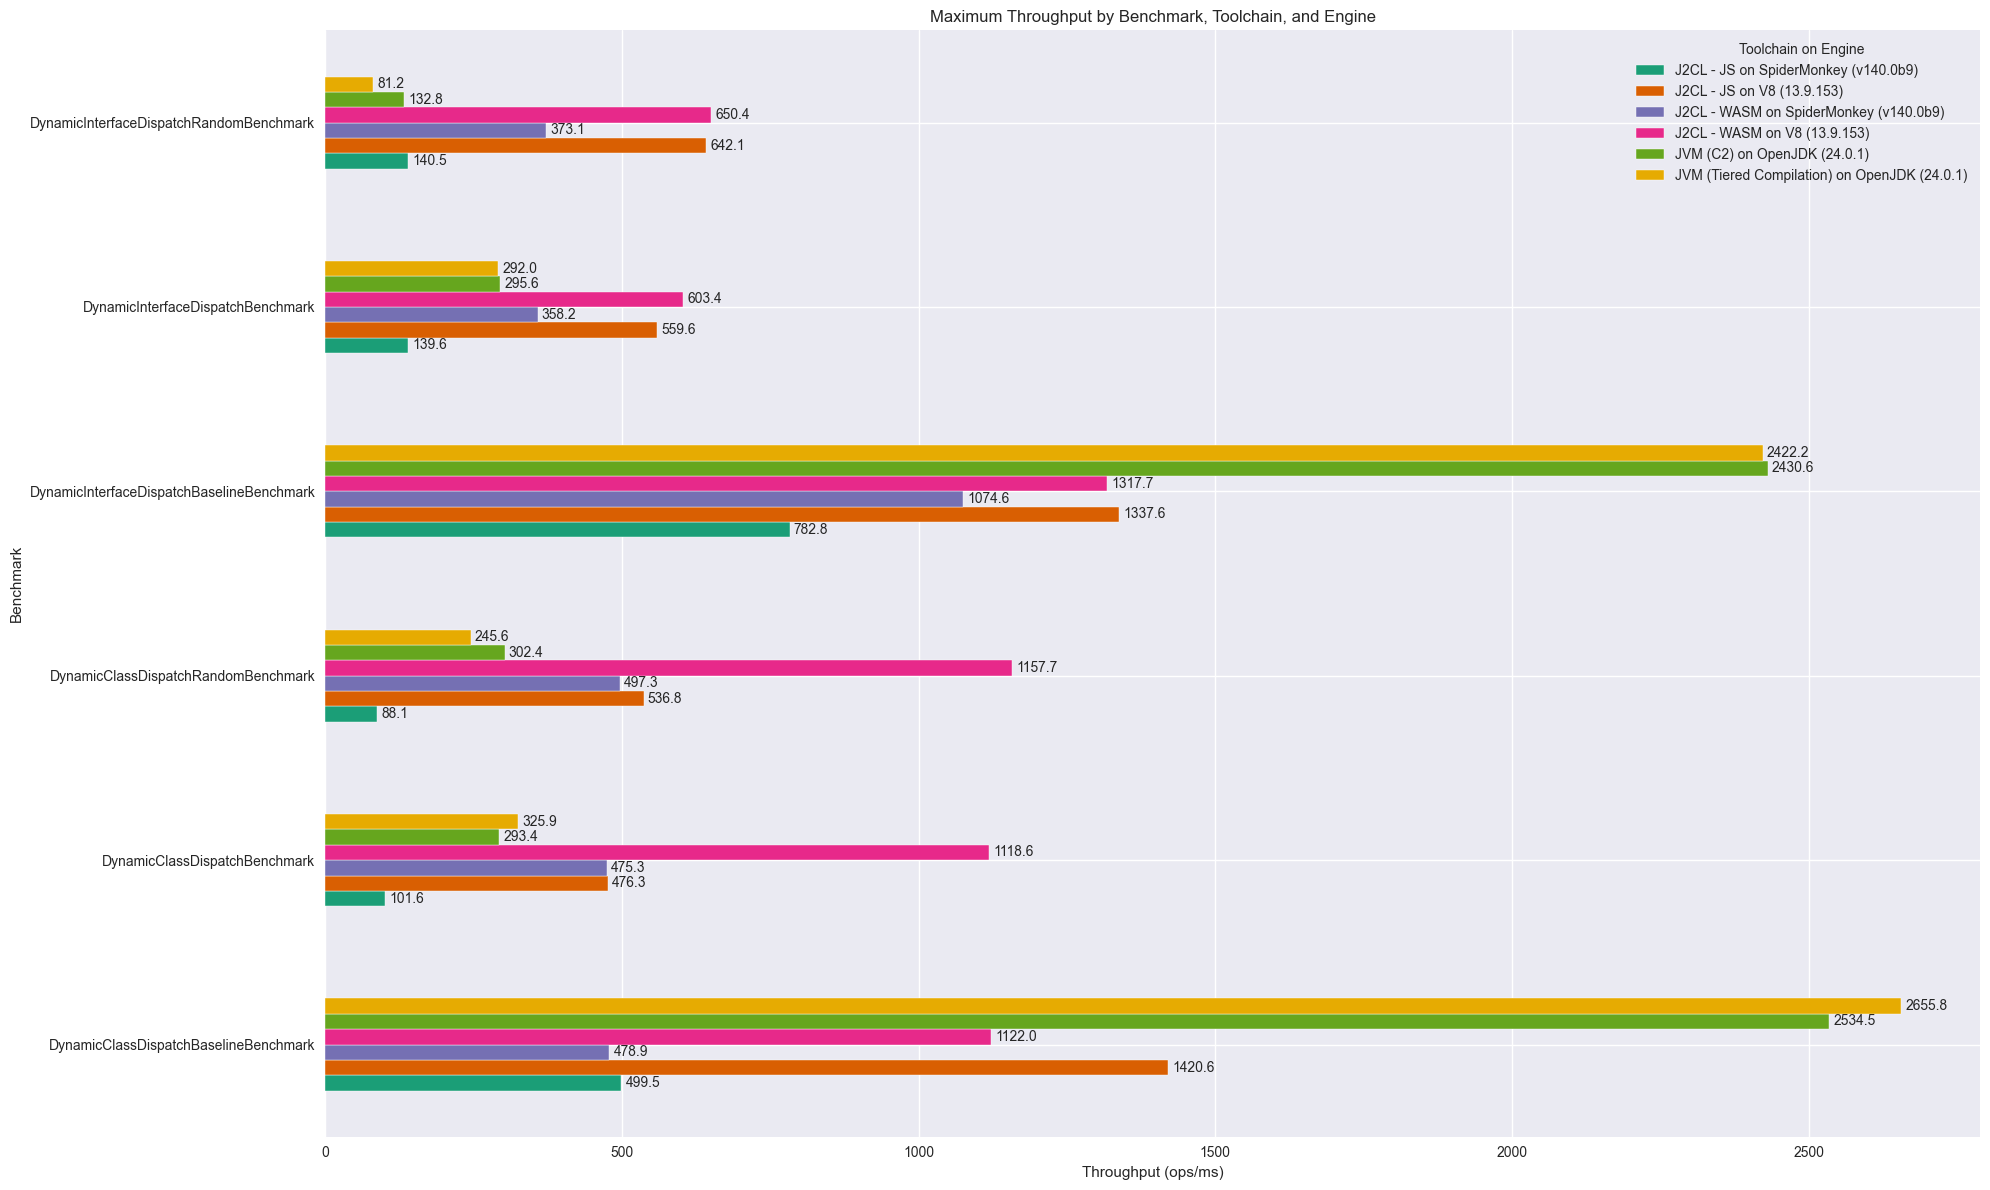

In [8]:
dispatch_benchmarks = [
    'DynamicClassDispatchBaselineBenchmark',
    'DynamicClassDispatchBenchmark',
    'DynamicClassDispatchRandomBenchmark',
    'DynamicInterfaceDispatchBaselineBenchmark',
    'DynamicInterfaceDispatchBenchmark',
    'DynamicInterfaceDispatchRandomBenchmark',
]

dispatch_data = data[data['Benchmark'].isin(dispatch_benchmarks)]

# Group by Benchmark, Toolchain, and Engine to take Engine into account
dispatch_max_throughput = dispatch_data.groupby(['Benchmark', 'Toolchain', 'Engine'])['Throughput (ops/ms)'].max().reset_index()

# Create a pivot table with Benchmark as rows and Toolchain+Engine as columns
# Combine Toolchain and Engine into a single column for better identification
dispatch_max_throughput['Toolchain_Engine'] = dispatch_max_throughput['Toolchain'] + ' on ' + dispatch_max_throughput['Engine']
dispatch_pivot = dispatch_max_throughput.pivot(index='Benchmark', columns='Toolchain_Engine', values='Throughput (ops/ms)')

# Set pandas display options to prevent wrapping
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

# Display the table
print("Maximum throughput for each benchmark, toolchain, and engine (ops/ms):")
print(dispatch_pivot)

# Set up the figure and axis with larger size to accommodate longer toolchain and engine names
plt.figure(figsize=(20, 12))
ax = dispatch_pivot.plot(kind='barh', figsize=(20, 12))

# Add labels and title
plt.ylabel('Benchmark')
plt.xlabel('Throughput (ops/ms)')
plt.title('Maximum Throughput by Benchmark, Toolchain, and Engine')

# Add a legend
plt.legend(title='Toolchain on Engine')

# Add value labels at the end of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()


## `instanceof`

Maximum throughput for each benchmark, toolchain, and engine (ops/ms):
Toolchain_Engine             J2CL - JS on SpiderMonkey (v140.0b9)  J2CL - JS on V8 (13.9.153)  J2CL - WASM on SpiderMonkey (v140.0b9)  J2CL - WASM on V8 (13.9.153)  JVM (C2) on OpenJDK (24.0.1)  JVM (Tiered Compilation) on OpenJDK (24.0.1)
Benchmark                                                                                                                                                                                                                                      
InstanceOfBaselineBenchmark                            316.731239                  560.429108                              926.261563                   1145.691788                   2937.496709                                   2817.370194
InstanceOfBenchmark                                    291.011913                  460.912550                              651.744934                   1003.016912                   2053.542537                

<Figure size 2000x1200 with 0 Axes>

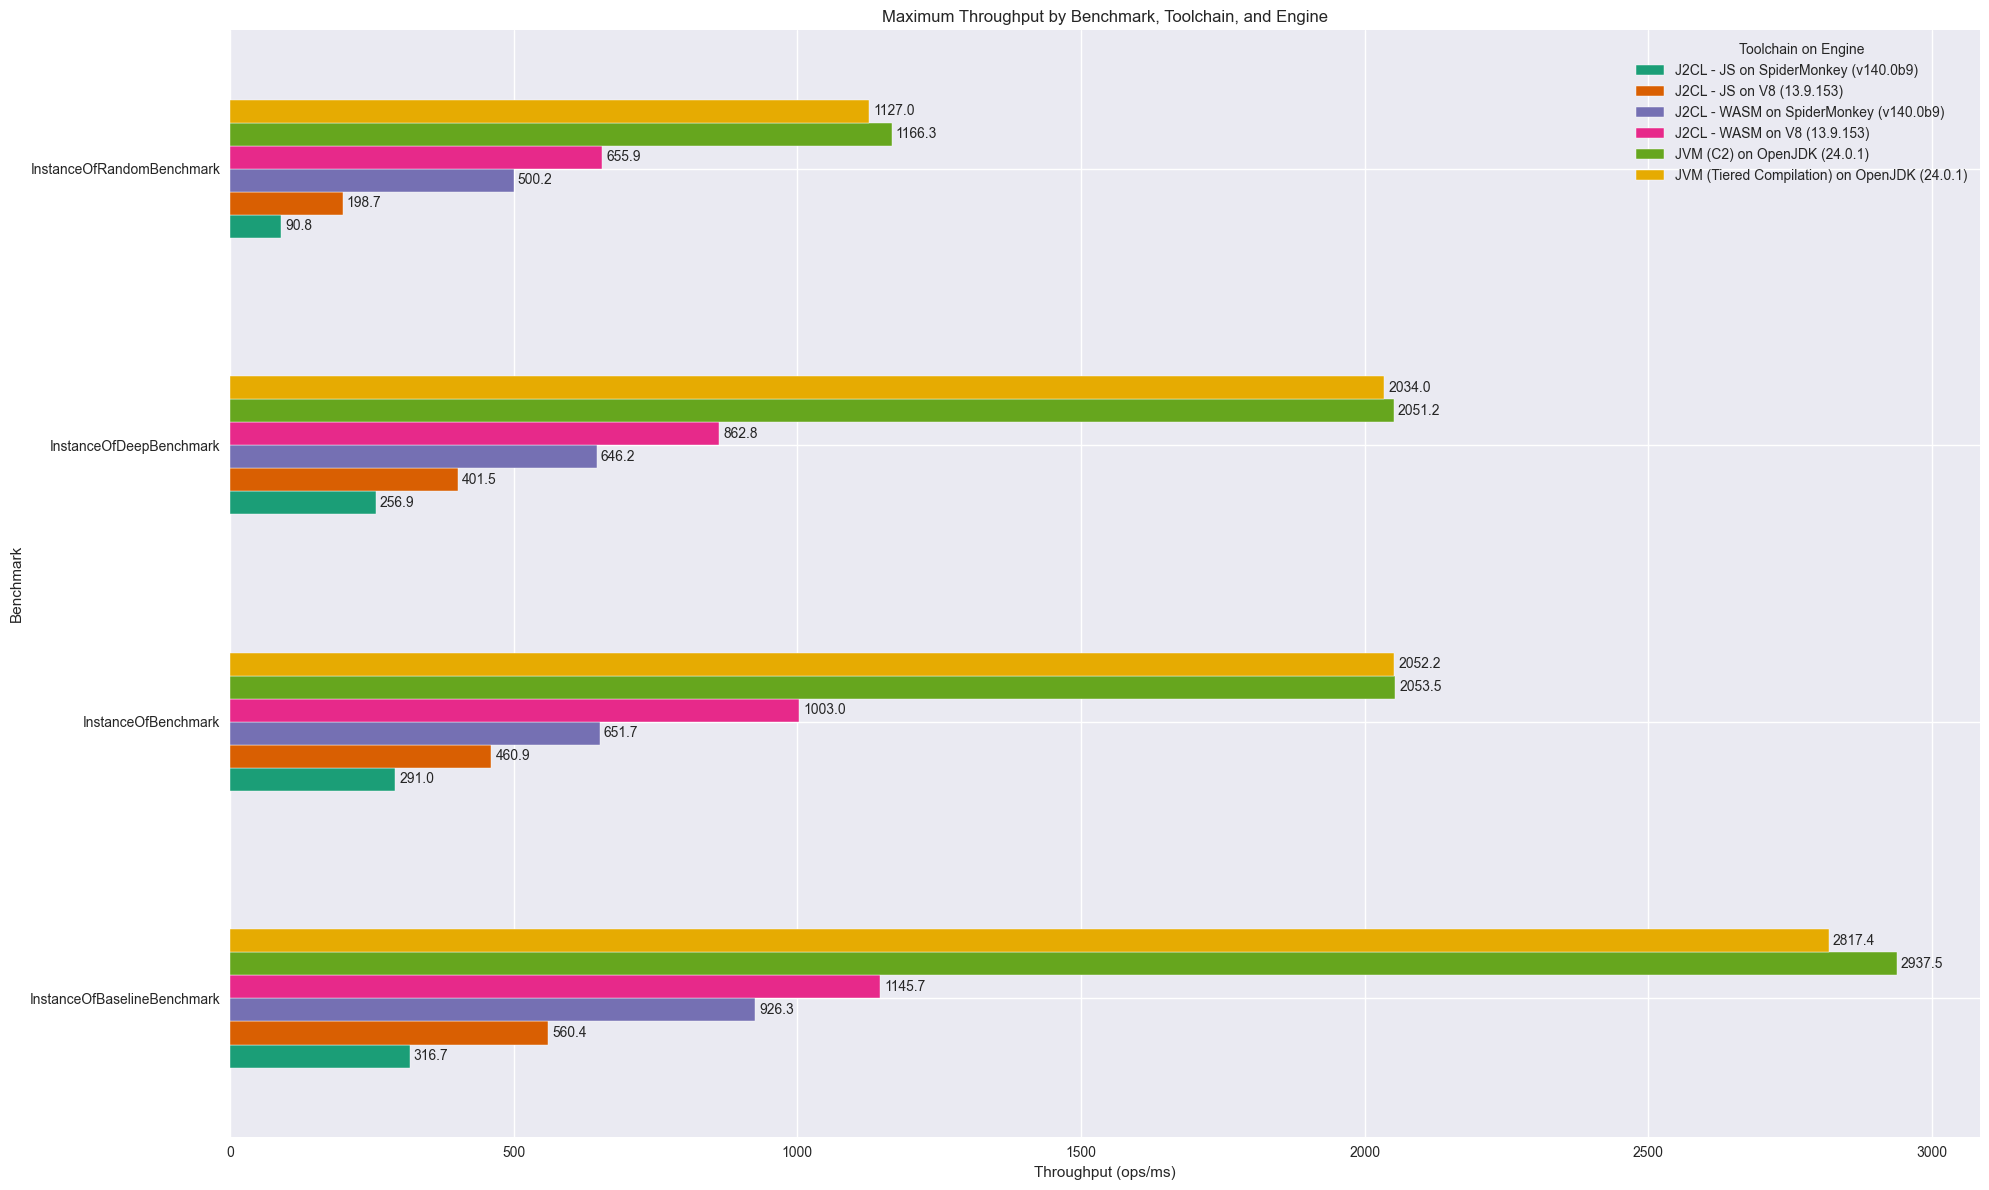

In [9]:
# Filter the data to include only the instanceof benchmarks
instanceof_benchmarks = [
    'InstanceOfBaselineBenchmark',
    'InstanceOfBenchmark',
    'InstanceOfDeepBenchmark',
    'InstanceOfRandomBenchmark',
]

instanceof_data = data[data['Benchmark'].isin(instanceof_benchmarks)]

# Group by Benchmark, Toolchain, and Engine to take Engine into account
instanceof_max_throughput = instanceof_data.groupby(['Benchmark', 'Toolchain', 'Engine'])['Throughput (ops/ms)'].max().reset_index()

# Create a pivot table with Benchmark as rows and Toolchain+Engine as columns
# Combine Toolchain and Engine into a single column for better identification
instanceof_max_throughput['Toolchain_Engine'] = instanceof_max_throughput['Toolchain'] + ' on ' + instanceof_max_throughput['Engine']
instanceof_pivot = instanceof_max_throughput.pivot(index='Benchmark', columns='Toolchain_Engine', values='Throughput (ops/ms)')

# Set pandas display options to prevent wrapping
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

# Display the table
print("Maximum throughput for each benchmark, toolchain, and engine (ops/ms):")
print(instanceof_pivot)

# Set up the figure and axis with larger size to accommodate longer toolchain and engine names
plt.figure(figsize=(20, 12))
ax = instanceof_pivot.plot(kind='barh', figsize=(20, 12))

# Add labels and title
plt.ylabel('Benchmark')
plt.xlabel('Throughput (ops/ms)')
plt.title('Maximum Throughput by Benchmark, Toolchain, and Engine')

# Add a legend
plt.legend(title='Toolchain on Engine')

# Add value labels at the end of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()


## Downcast

Maximum throughput for each benchmark, toolchain, and engine (ops/ms):
Toolchain_Engine       J2CL - JS on SpiderMonkey (v140.0b9)  J2CL - JS on V8 (13.9.153)  J2CL - WASM on SpiderMonkey (v140.0b9)  J2CL - WASM on V8 (13.9.153)  JVM (C2) on OpenJDK (24.0.1)  JVM (Tiered Compilation) on OpenJDK (24.0.1)
Benchmark                                                                                                                                                                                                                                
CastBaselineBenchmark                            802.738666                 1461.244089                             1093.466436                   1447.336019                   2430.151717                                   2380.824879
CastBenchmark                                     78.821668                  183.781485                              499.170821                    674.648511                    893.808163                                    857.

<Figure size 2000x1200 with 0 Axes>

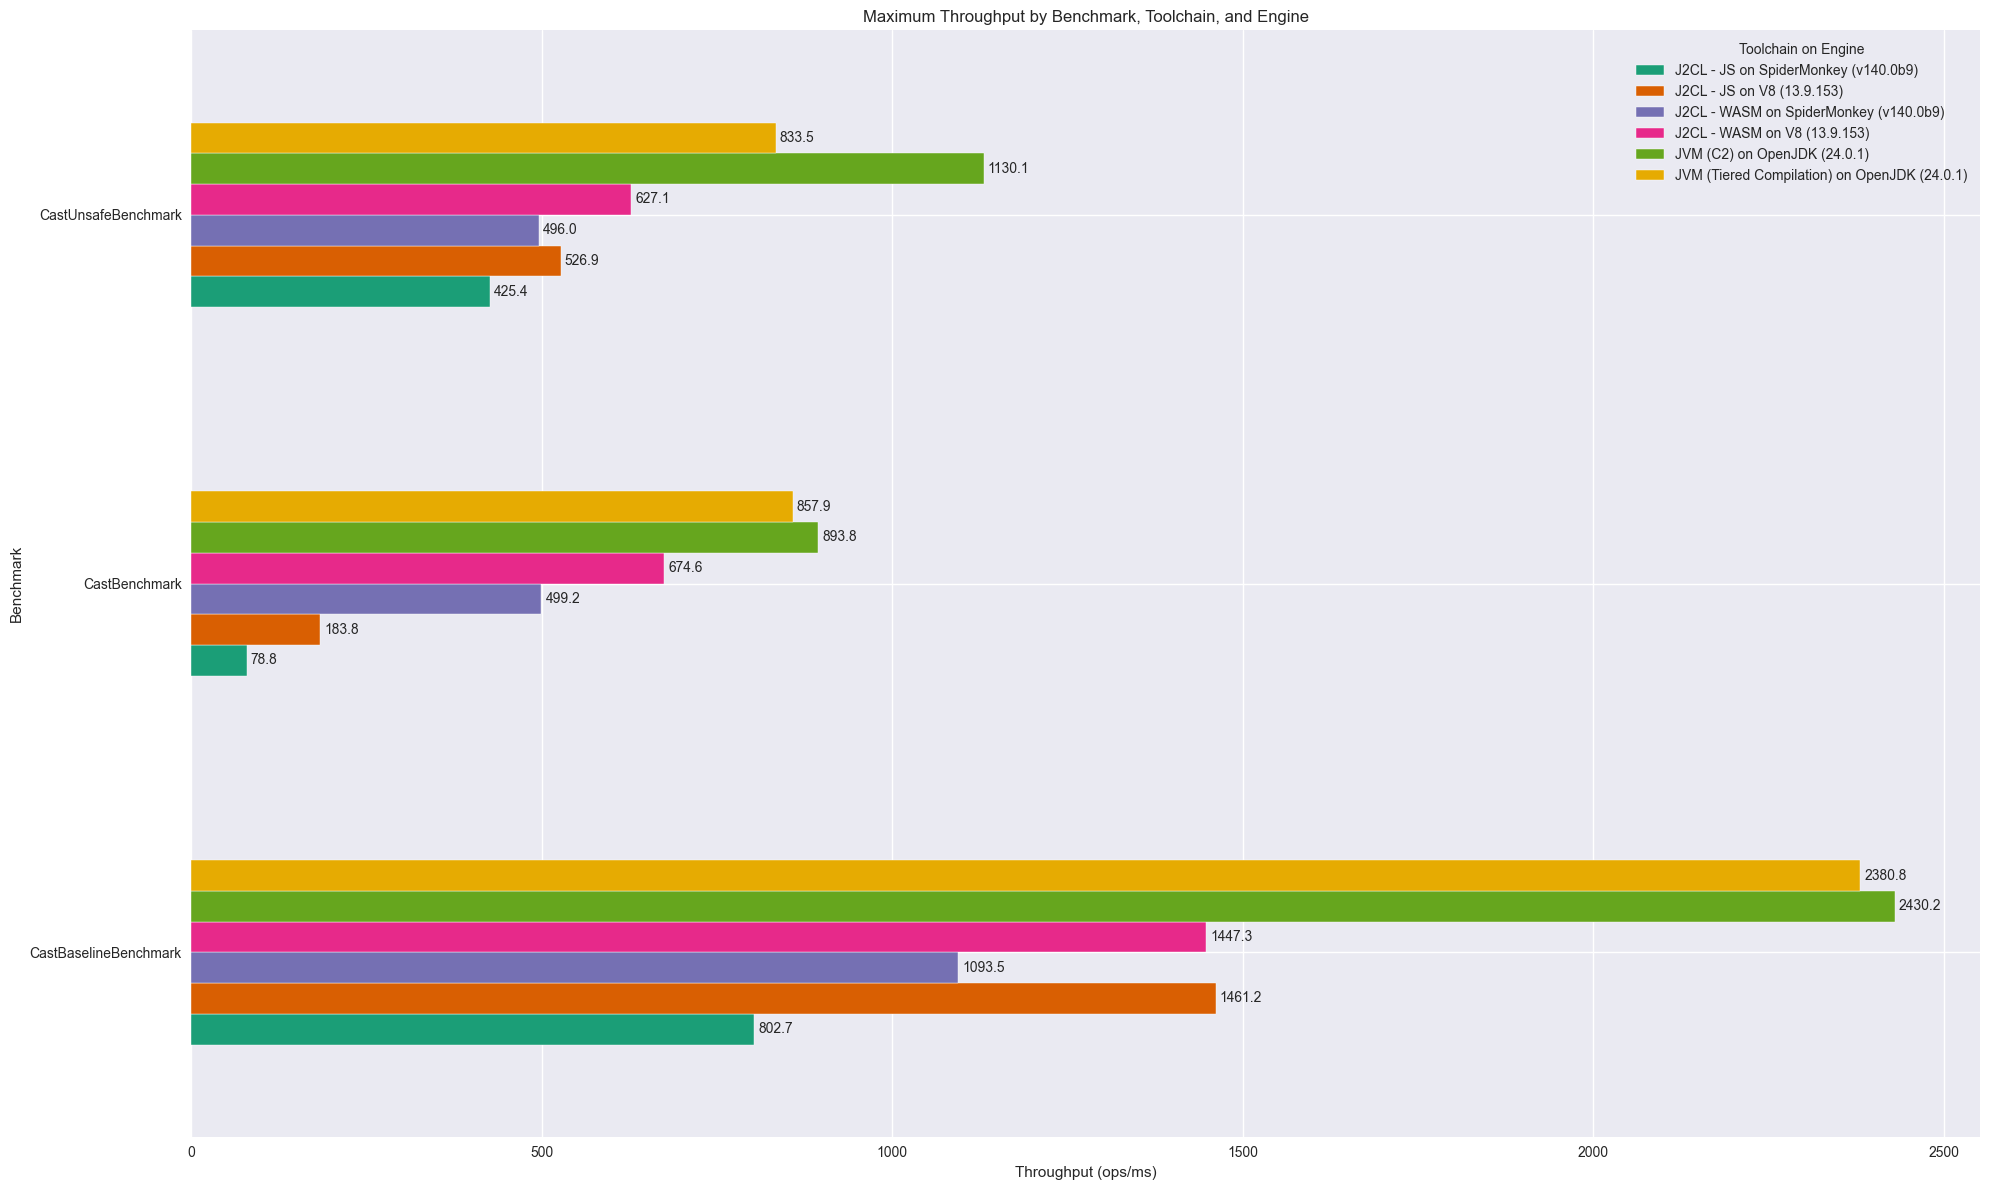

In [10]:
# Filter the data to include only the cast benchmarks
cast_benchmarks = [
    'CastBaselineBenchmark',
    'CastBenchmark',
    'CastUnsafeBenchmark',
]

cast_data = data[data['Benchmark'].isin(cast_benchmarks)]

# Group by Benchmark, Toolchain, and Engine to take Engine into account
cast_max_throughput = cast_data.groupby(['Benchmark', 'Toolchain', 'Engine'])['Throughput (ops/ms)'].max().reset_index()

# Create a pivot table with Benchmark as rows and Toolchain+Engine as columns
# Combine Toolchain and Engine into a single column for better identification
cast_max_throughput['Toolchain_Engine'] = cast_max_throughput['Toolchain'] + ' on ' + cast_max_throughput['Engine']
cast_pivot = cast_max_throughput.pivot(index='Benchmark', columns='Toolchain_Engine', values='Throughput (ops/ms)')

# Set pandas display options to prevent wrapping
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

# Display the table
print("Maximum throughput for each benchmark, toolchain, and engine (ops/ms):")
print(cast_pivot)

# Set up the figure and axis with larger size to accommodate longer toolchain and engine names
plt.figure(figsize=(20, 12))
ax = cast_pivot.plot(kind='barh', figsize=(20, 12))

# Add labels and title
plt.ylabel('Benchmark')
plt.xlabel('Throughput (ops/ms)')
plt.title('Maximum Throughput by Benchmark, Toolchain, and Engine')

# Add a legend
plt.legend(title='Toolchain on Engine')

# Add value labels at the end of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()

## Object churn

Maximum throughput for each benchmark, toolchain, and engine (ops/ms):
Toolchain_Engine              J2CL - JS on SpiderMonkey (v140.0b9)  J2CL - JS on V8 (13.9.153)  J2CL - WASM on SpiderMonkey (v140.0b9)  J2CL - WASM on V8 (13.9.153)  JVM (C2) on OpenJDK (24.0.1)  JVM (Tiered Compilation) on OpenJDK (24.0.1)
Benchmark                                                                                                                                                                                                                                       
ObjectChurnBaselineBenchmark                              4.735498                    7.459829                               47.703202                     66.310860                    110.118710                                    119.529275
ObjectChurnMixedBenchmark                                 1.781621                    2.237677                                2.580196                      4.982707                      6.810164            

<Figure size 2000x1200 with 0 Axes>

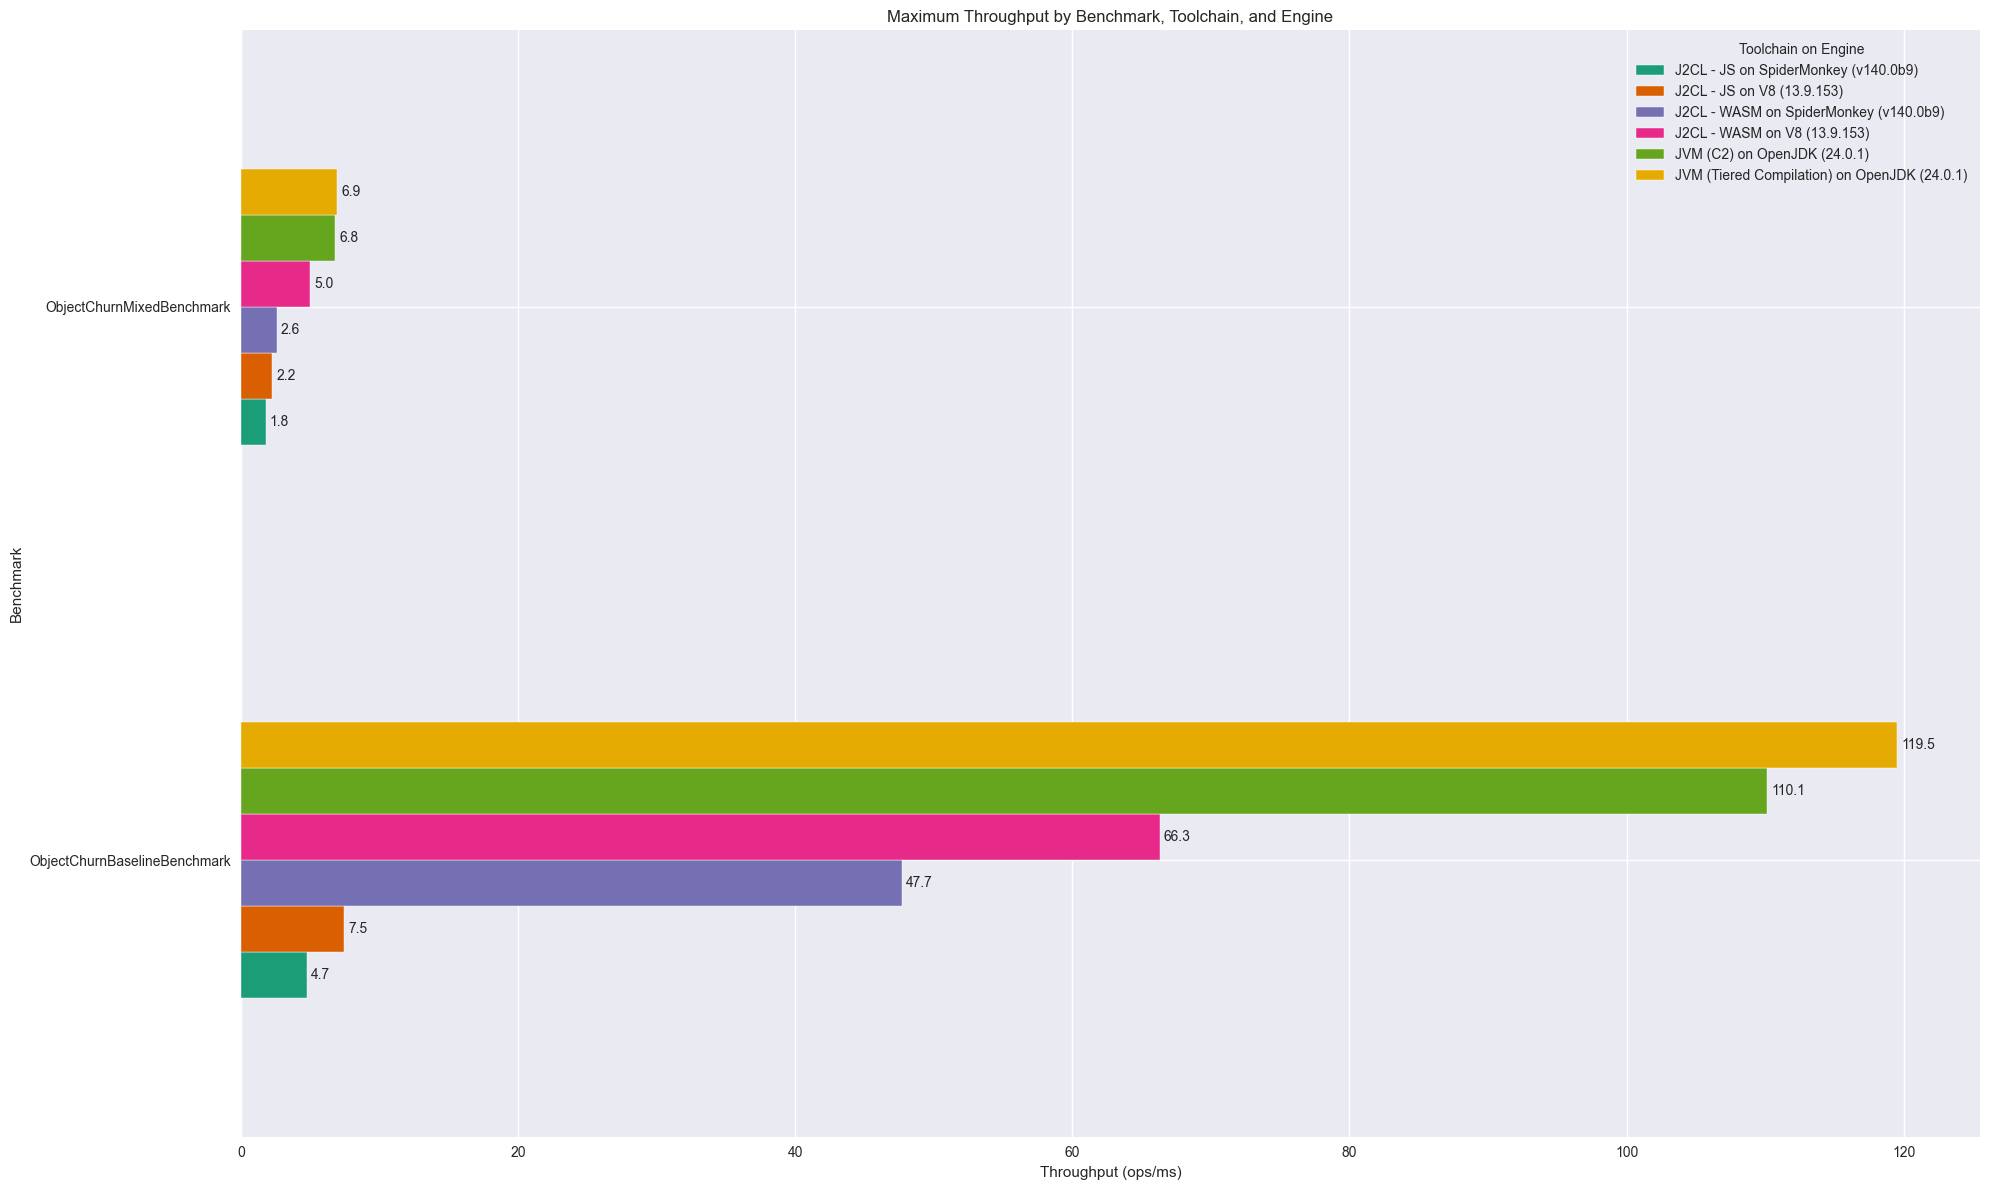

In [11]:
# Filter the data to include only the churn benchmarks
churn_benchmarks = [
    'ObjectChurnBaselineBenchmark',
    'ObjectChurnMixedBenchmark',
]

churn_data = data[data['Benchmark'].isin(churn_benchmarks)]

# Group by Benchmark, Toolchain, and Engine to take Engine into account
churn_max_throughput = churn_data.groupby(['Benchmark', 'Toolchain', 'Engine'])['Throughput (ops/ms)'].max().reset_index()

# Create a pivot table with Benchmark as rows and Toolchain+Engine as columns
# Combine Toolchain and Engine into a single column for better identification
churn_max_throughput['Toolchain_Engine'] = churn_max_throughput['Toolchain'] + ' on ' + churn_max_throughput['Engine']
churn_pivot = churn_max_throughput.pivot(index='Benchmark', columns='Toolchain_Engine', values='Throughput (ops/ms)')

# Set pandas display options to prevent wrapping
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

# Display the table
print("Maximum throughput for each benchmark, toolchain, and engine (ops/ms):")
print(churn_pivot)

# Set up the figure and axis with larger size to accommodate longer toolchain and engine names
plt.figure(figsize=(20, 12))
ax = churn_pivot.plot(kind='barh', figsize=(20, 12))

# Add labels and title
plt.ylabel('Benchmark')
plt.xlabel('Throughput (ops/ms)')
plt.title('Maximum Throughput by Benchmark, Toolchain, and Engine')

# Add a legend
plt.legend(title='Toolchain on Engine')

# Add value labels at the end of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()

## Boxing & unboxing

Maximum throughput for each benchmark, toolchain, and engine (ops/ms):
Toolchain_Engine         J2CL - JS on SpiderMonkey (v140.0b9)  J2CL - JS on V8 (13.9.153)  J2CL - WASM on SpiderMonkey (v140.0b9)  J2CL - WASM on V8 (13.9.153)  JVM (C2) on OpenJDK (24.0.1)  JVM (Tiered Compilation) on OpenJDK (24.0.1)
Benchmark                                                                                                                                                                                                                                  
BoxingBaselineBenchmark                            921.116987                 1931.716978                             2369.598030                   1536.006569                   6397.950172                                   6447.815965
BoxingBenchmark                                    106.223759                  201.004190                               45.144731                    201.176978                    291.613667                                

<Figure size 2000x1200 with 0 Axes>

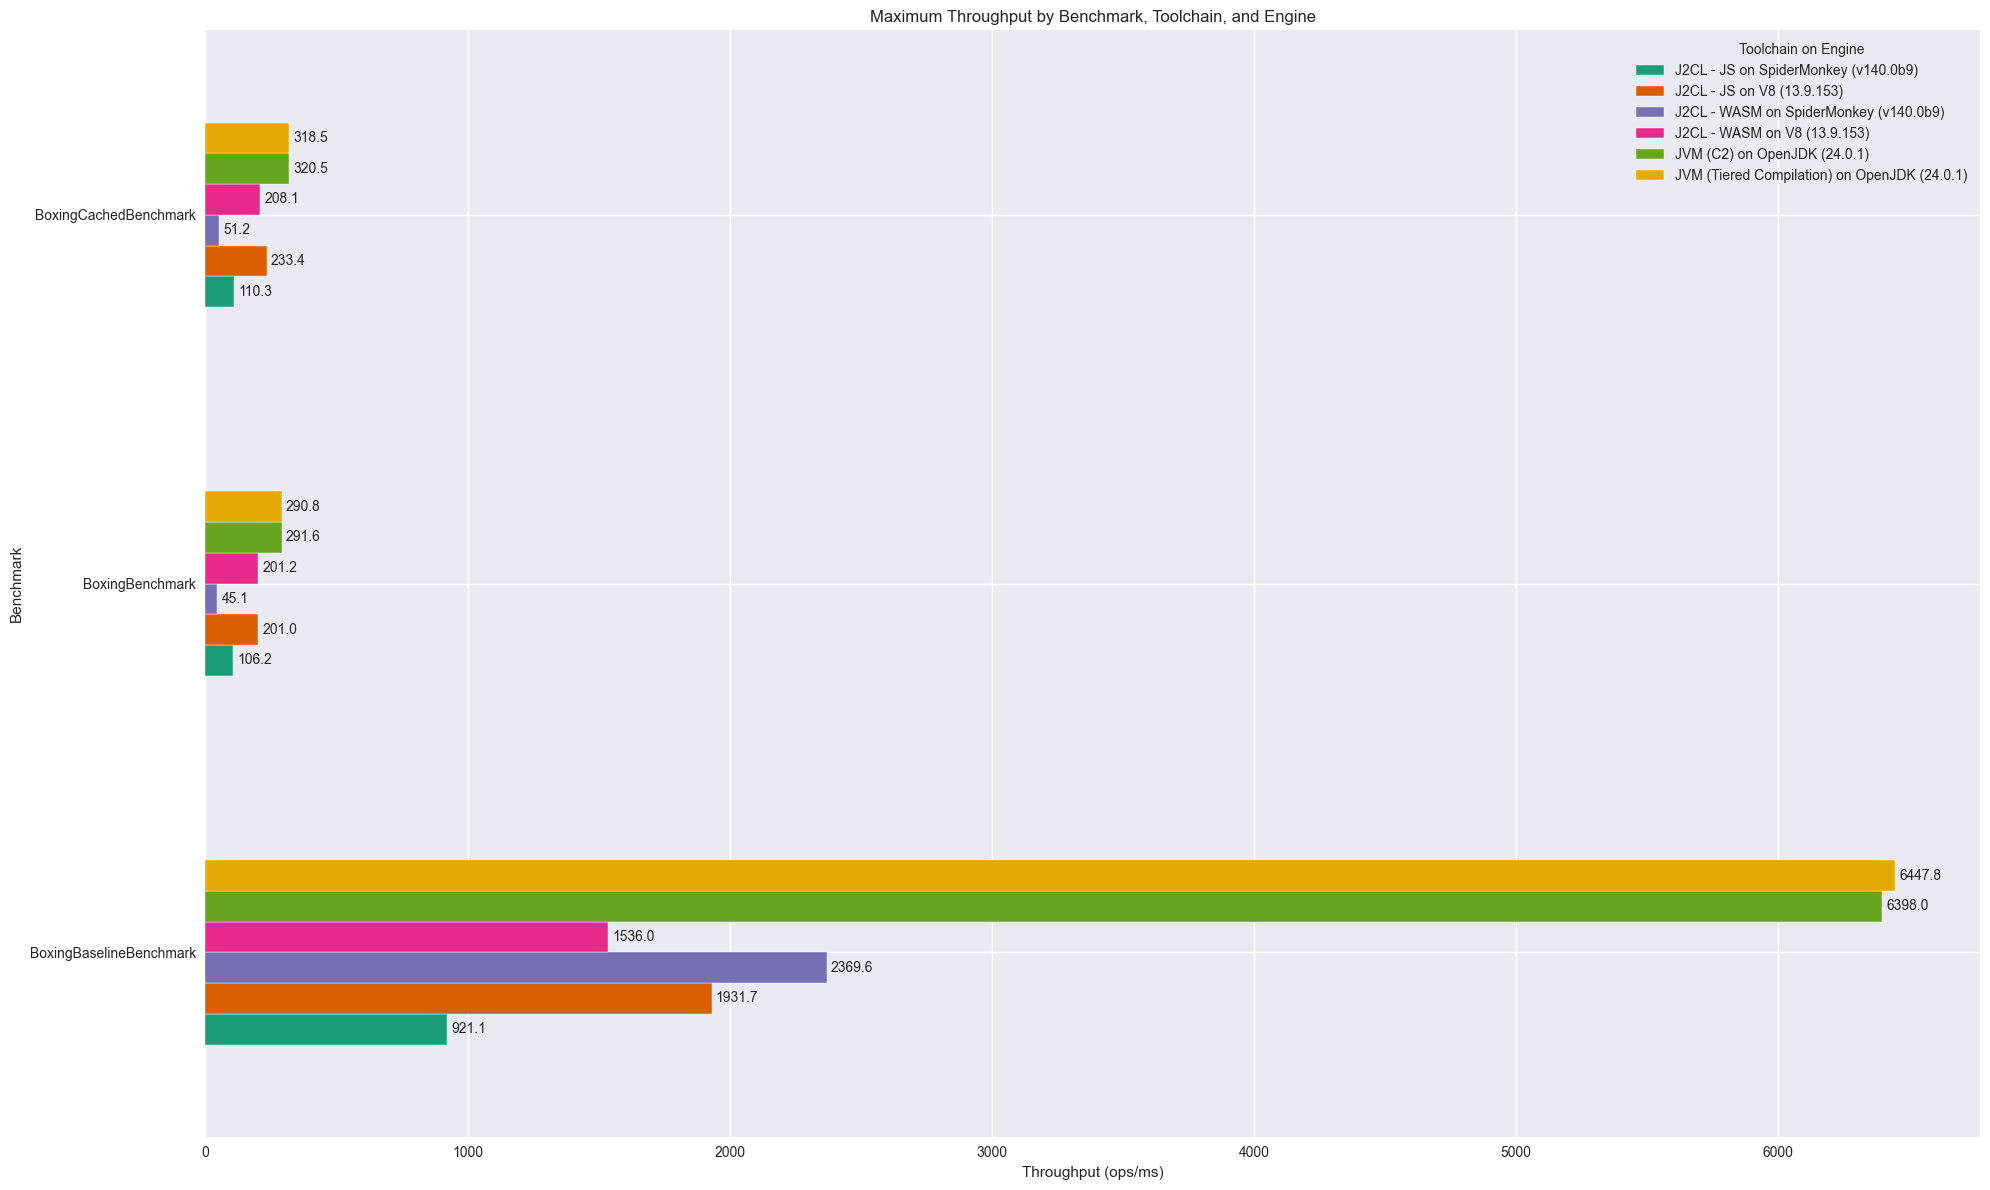

In [12]:
# Filter the data to include only the boxing benchmarks
boxing_benchmarks = [
    'BoxingBaselineBenchmark',
    'BoxingBenchmark',
    'BoxingCachedBenchmark',
]

boxing_data = data[data['Benchmark'].isin(boxing_benchmarks)]

# Group by Benchmark, Toolchain, and Engine to take Engine into account
boxing_max_throughput = boxing_data.groupby(['Benchmark', 'Toolchain', 'Engine'])['Throughput (ops/ms)'].max().reset_index()

# Create a pivot table with Benchmark as rows and Toolchain+Engine as columns
# Combine Toolchain and Engine into a single column for better identification
boxing_max_throughput['Toolchain_Engine'] = boxing_max_throughput['Toolchain'] + ' on ' + boxing_max_throughput['Engine']
boxing_pivot = boxing_max_throughput.pivot(index='Benchmark', columns='Toolchain_Engine', values='Throughput (ops/ms)')

# Set pandas display options to prevent wrapping
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

# Display the table
print("Maximum throughput for each benchmark, toolchain, and engine (ops/ms):")
print(boxing_pivot)

# Set up the figure and axis with larger size to accommodate longer toolchain and engine names
plt.figure(figsize=(20, 12))
ax = boxing_pivot.plot(kind='barh', figsize=(20, 12))

# Add labels and title
plt.ylabel('Benchmark')
plt.xlabel('Throughput (ops/ms)')
plt.title('Maximum Throughput by Benchmark, Toolchain, and Engine')

# Add a legend
plt.legend(title='Toolchain on Engine')

# Add value labels at the end of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()

## `ArrayList`

Maximum throughput for each benchmark, toolchain, and engine (ops/ms):
Toolchain_Engine                   J2CL - JS on SpiderMonkey (v140.0b9)  J2CL - JS on V8 (13.9.153)  J2CL - WASM on SpiderMonkey (v140.0b9)  J2CL - WASM on V8 (13.9.153)  JVM (C2) on OpenJDK (24.0.1)  JVM (Tiered Compilation) on OpenJDK (24.0.1)
Benchmark                                                                                                                                                                                                                                            
ArrayListObjectAddBenchmark                                  310.804569                  266.206423                               82.455330                    321.755213                    347.062995                                    268.655392
ArrayListObjectGetBenchmark                                  456.699840                 1560.676406                             1112.304315                   1528.069559                   539

<Figure size 2000x1200 with 0 Axes>

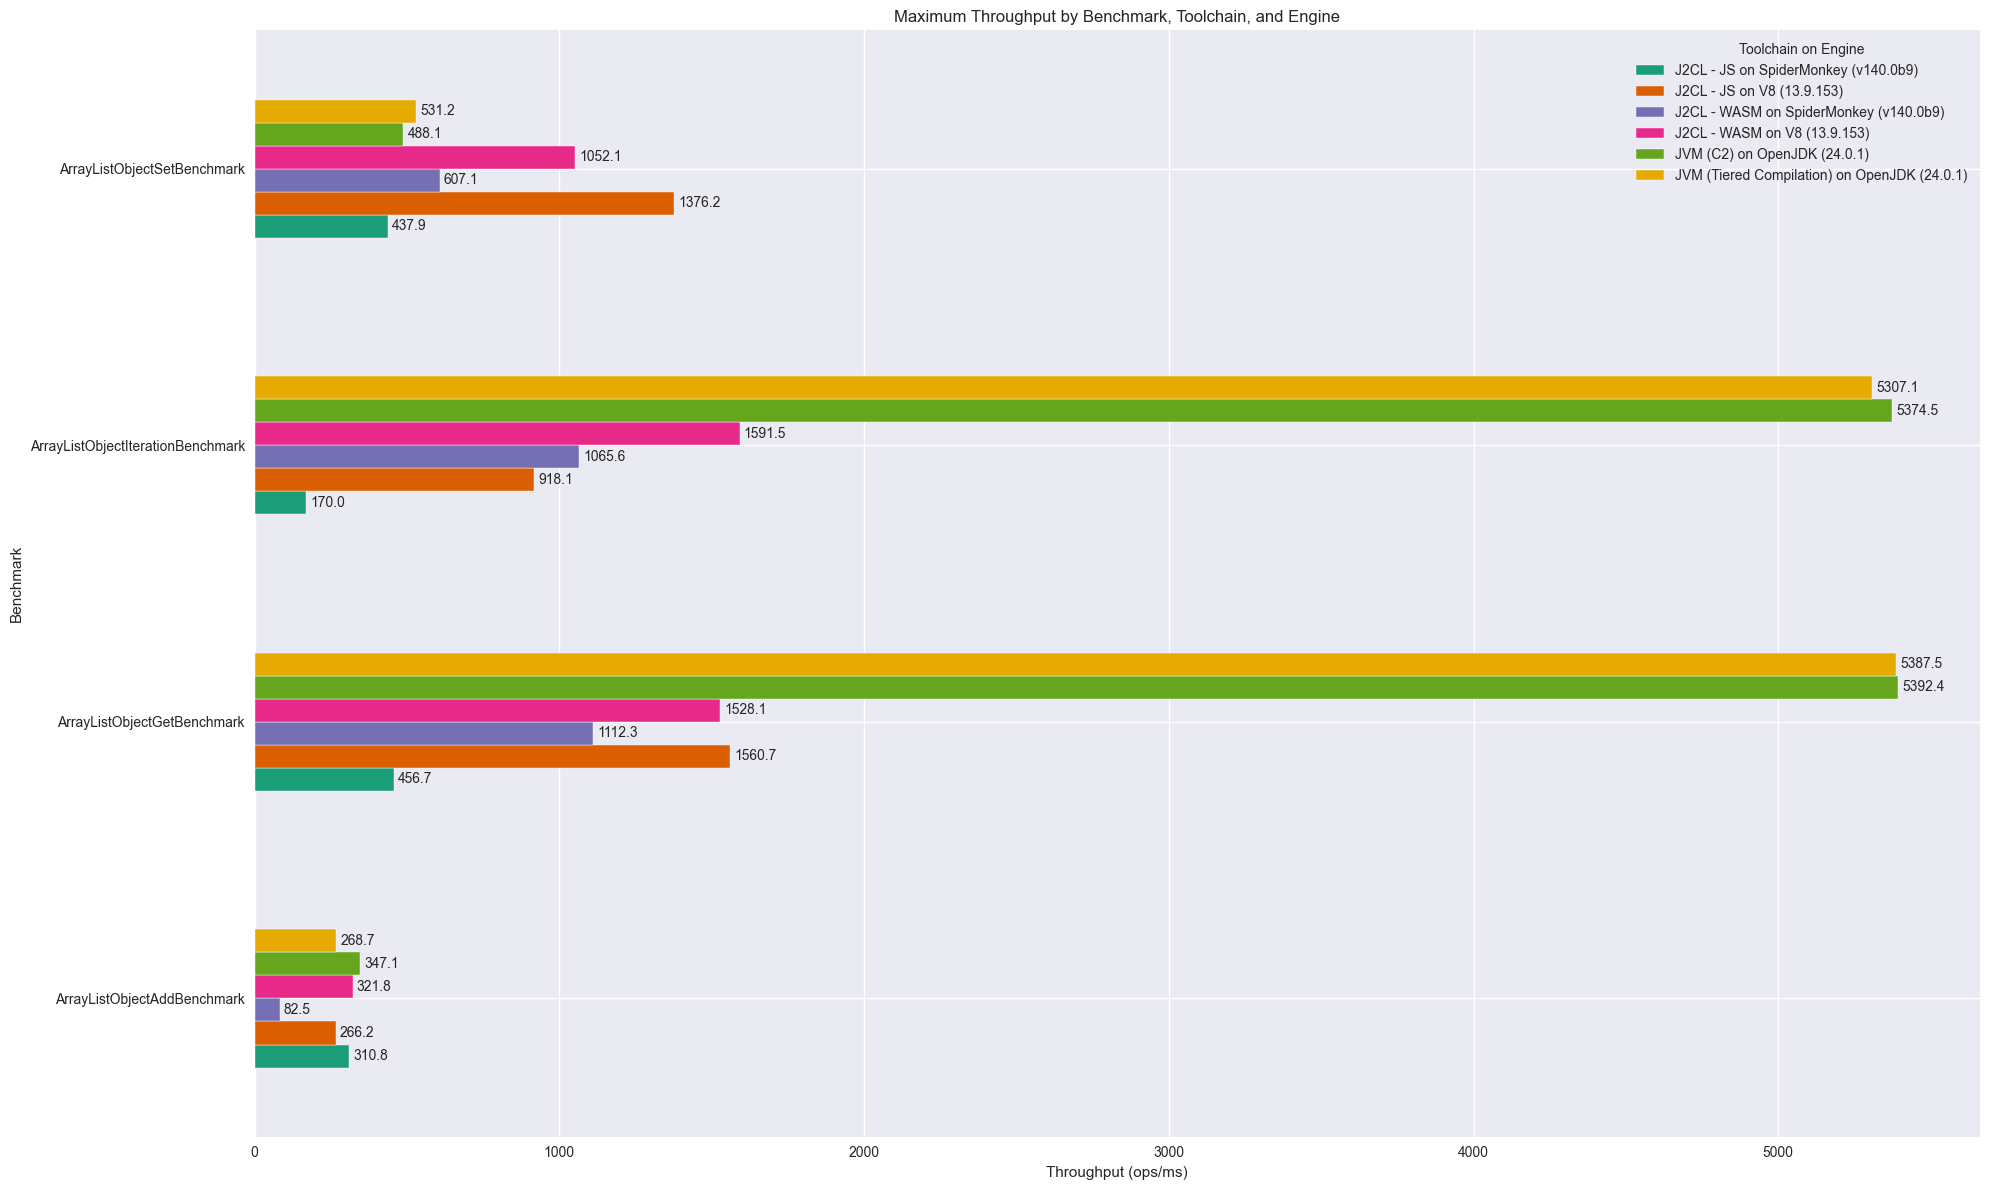

In [13]:
# Filter the data to include only the list benchmarks
list_benchmarks = [
    'ArrayListObjectAddBenchmark',
    'ArrayListObjectGetBenchmark',
    'ArrayListObjectIterationBenchmark',
    'ArrayListObjectSetBenchmark',
]

list_data = data[data['Benchmark'].isin(list_benchmarks)]

# Group by Benchmark, Toolchain, and Engine to take Engine into account
list_max_throughput = list_data.groupby(['Benchmark', 'Toolchain', 'Engine'])['Throughput (ops/ms)'].max().reset_index()

# Create a pivot table with Benchmark as rows and Toolchain+Engine as columns
# Combine Toolchain and Engine into a single column for better identification
list_max_throughput['Toolchain_Engine'] = list_max_throughput['Toolchain'] + ' on ' + list_max_throughput['Engine']
list_pivot = list_max_throughput.pivot(index='Benchmark', columns='Toolchain_Engine', values='Throughput (ops/ms)')

# Set pandas display options to prevent wrapping
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

# Display the table
print("Maximum throughput for each benchmark, toolchain, and engine (ops/ms):")
print(list_pivot)

# Set up the figure and axis with larger size to accommodate longer toolchain and engine names
plt.figure(figsize=(20, 12))
ax = list_pivot.plot(kind='barh', figsize=(20, 12))

# Add labels and title
plt.ylabel('Benchmark')
plt.xlabel('Throughput (ops/ms)')
plt.title('Maximum Throughput by Benchmark, Toolchain, and Engine')

# Add a legend
plt.legend(title='Toolchain on Engine')

# Add value labels at the end of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()

## `HashMap`

Maximum throughput for each benchmark, toolchain, and engine (ops/ms):
Toolchain_Engine                           J2CL - JS on SpiderMonkey (v140.0b9)  J2CL - JS on V8 (13.9.153)  J2CL - WASM on SpiderMonkey (v140.0b9)  J2CL - WASM on V8 (13.9.153)  JVM (C2) on OpenJDK (24.0.1)  JVM (Tiered Compilation) on OpenJDK (24.0.1)
Benchmark                                                                                                                                                                                                                                                    
HashMapStringContainsKeyBenchmark                                     10.591954                   32.540197                               56.168385                     83.995508                    353.381391                                    249.045541
HashMapStringContainsValueBenchmark                                    0.014185                    0.070435                                0.036443                    

<Figure size 2000x1200 with 0 Axes>

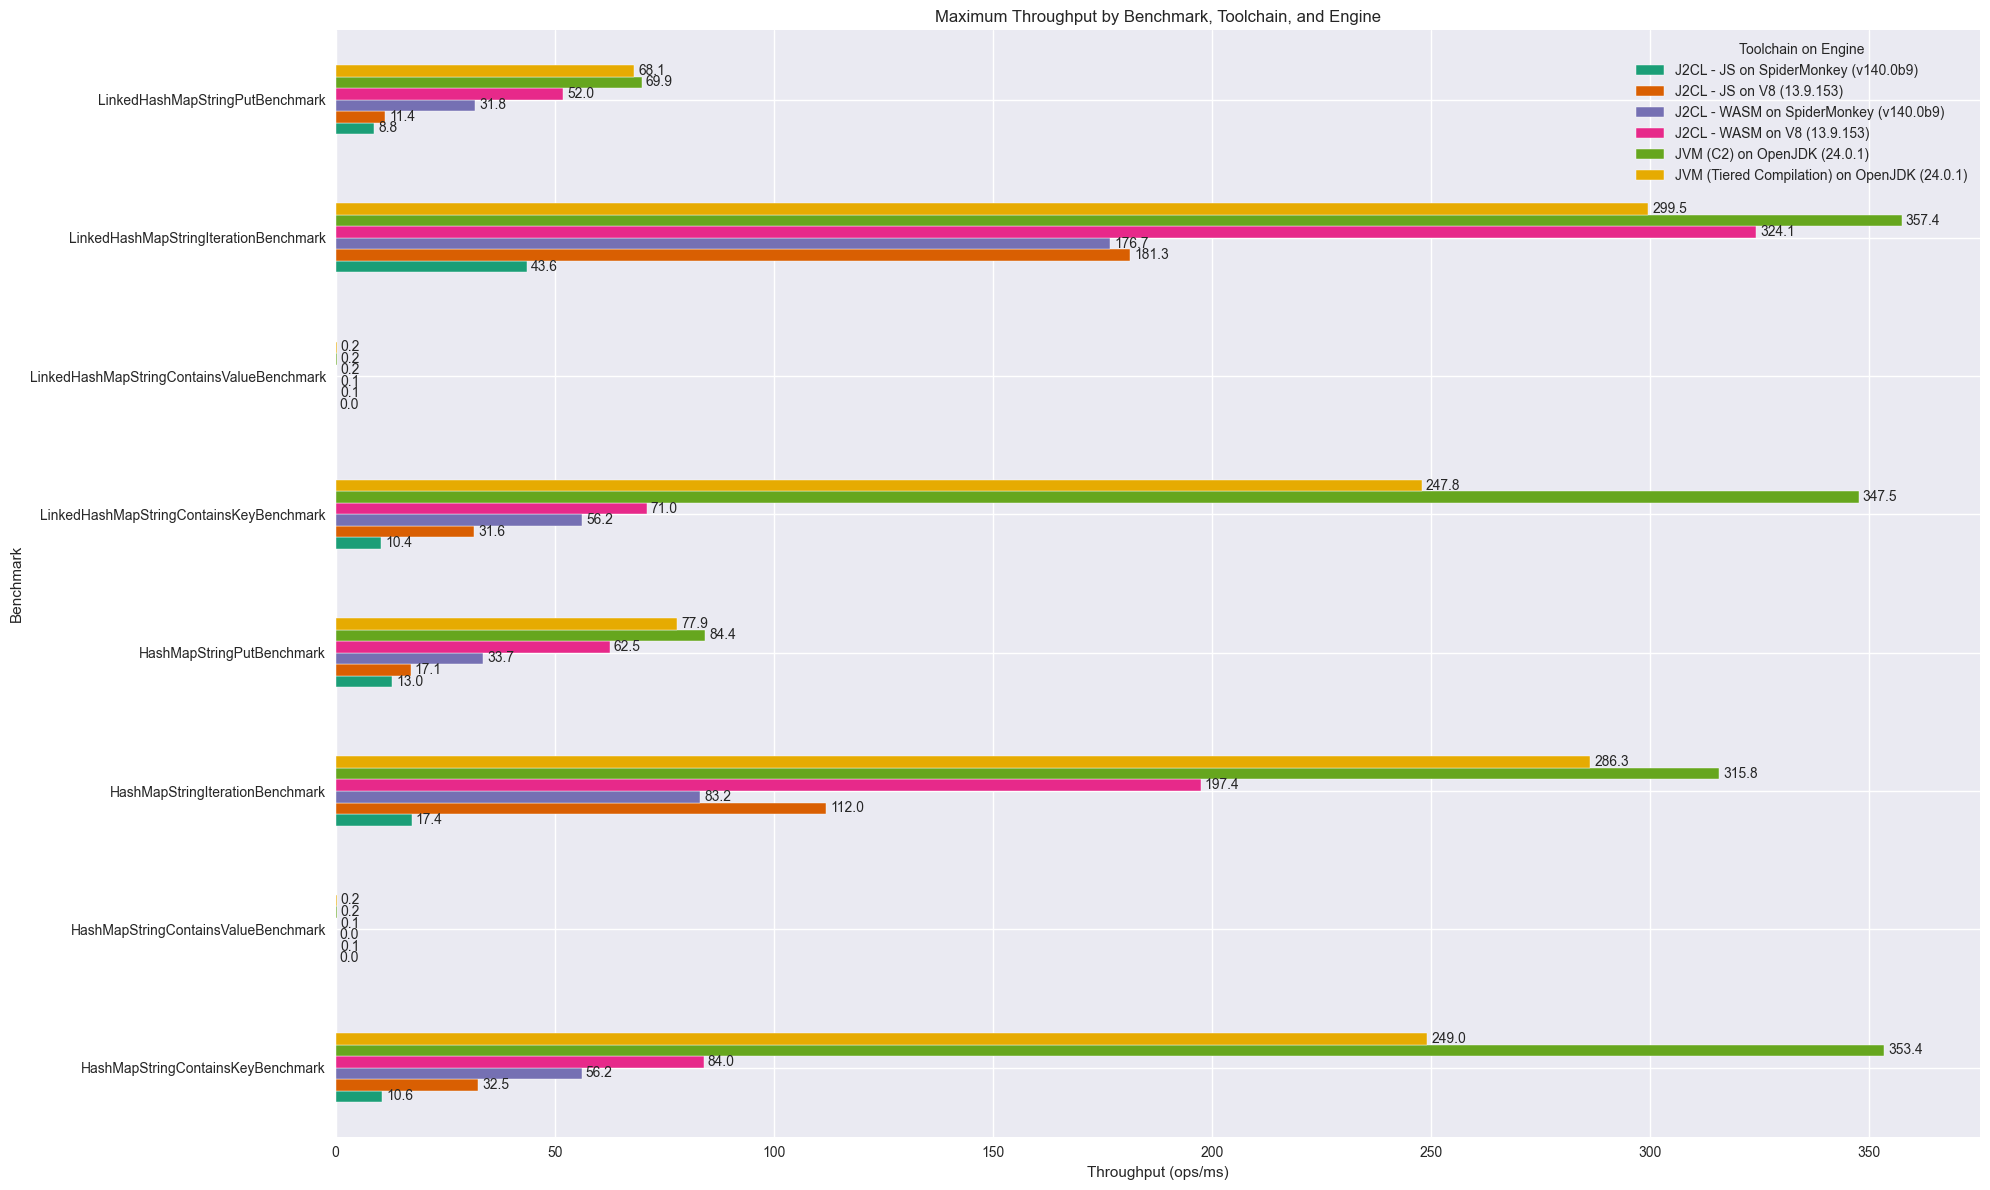

In [14]:
# Filter the data to include only the map benchmarks
map_benchmarks = [
    'HashMapStringContainsKeyBenchmark',
    'LinkedHashMapStringContainsKeyBenchmark',
    'HashMapStringContainsValueBenchmark',
    'LinkedHashMapStringContainsValueBenchmark',
    'HashMapStringPutBenchmark',
    'LinkedHashMapStringPutBenchmark',
    'HashMapStringIterationBenchmark',
    'LinkedHashMapStringIterationBenchmark',
]

map_data = data[data['Benchmark'].isin(map_benchmarks)]

# Group by Benchmark, Toolchain, and Engine to take Engine into account
map_max_throughput = map_data.groupby(['Benchmark', 'Toolchain', 'Engine'])['Throughput (ops/ms)'].max().reset_index()

# Create a pivot table with Benchmark as rows and Toolchain+Engine as columns
# Combine Toolchain and Engine into a single column for better identification
map_max_throughput['Toolchain_Engine'] = map_max_throughput['Toolchain'] + ' on ' + map_max_throughput['Engine']
map_pivot = map_max_throughput.pivot(index='Benchmark', columns='Toolchain_Engine', values='Throughput (ops/ms)')

# Set pandas display options to prevent wrapping
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

# Display the table
print("Maximum throughput for each benchmark, toolchain, and engine (ops/ms):")
print(map_pivot)

# Set up the figure and axis with larger size to accommodate longer toolchain and engine names
plt.figure(figsize=(20, 12))
ax = map_pivot.plot(kind='barh', figsize=(20, 12))

# Add labels and title
plt.ylabel('Benchmark')
plt.xlabel('Throughput (ops/ms)')
plt.title('Maximum Throughput by Benchmark, Toolchain, and Engine')

# Add a legend
plt.legend(title='Toolchain on Engine')

# Add value labels at the end of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()